In [1]:
import uproot # for data loading
import awkward as ak # for data manipulation
import numpy as np
import hist # for histogram filling (and some plotting)
import time
import matplotlib.pyplot as plt
import scipy.stats
import scipy
import os
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde



# $\color{red}{\text{loading data from files}}$

In [6]:
start = time.time()
# energies=[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
energies=[500, 1000, 2000, 3000]
Emap={}
Ecal_E={}
Ecal_E_rec={}

Hmap={}
Hcal_E={}
Hcal_E_rec={}

total_E={}

R={}

only_Hcal_R = {}
only_Hcal_frac = {} 

only_Ecal_R = {}
only_Ecal_frac = {} 

Ecal_frac={}
Hcal_frac={}

Ecal_z={}
Ecal_sigma_z={}
Ecal_sigma_t={}
Hcal_z={}
Hcal_sigma_z={}
Hcal_sigma_t={}
Ecal_E_clean={}
Ecal_z_clean={}
Ecal_sigma_z_clean={}
Ecal_sigma_t_clean={}
R_clean_Ecal={}
Hcal_E_clean={}
Hcal_z_clean={}
Hcal_sigma_z_clean={}
Hcal_sigma_t_clean={}
R_clean_Hcal={}
Hcal_z_Ecalclean={}
gun_E_Ecal={}
gun_E_Hcal={}

for i in energies:
    Emap[i]=uproot.open(f"/Users/gmy20020705/remote_LDMX/neutron_{i}MeV.root")
    # Ecal_E[i]=Emap[i]["LDMX_Events"].arrays(["EcalTotalEnergy_test"], library="ak")["EcalTotalEnergy_test"]
    Ecal_E_rec[i]=Emap[i]["LDMX_Events"].arrays(["EcalRecHits_test.energy_"], library="ak")["EcalRecHits_test.energy_"]
    HIP_mask=Ecal_E_rec[i]<200
    Ecal_E[i]=ak.sum(Ecal_E_rec[i][HIP_mask],axis=1)
    

    Hmap[i]=uproot.open(f"/Users/gmy20020705/remote_LDMX/neutron_{i}MeV.root")
    Hcal_E[i]=Hmap[i]["LDMX_Events"].arrays(["HcalTotalEnergy_test"], library="ak")["HcalTotalEnergy_test"]/0.09
    Hcal_E_rec[i]=Hmap[i]["LDMX_Events"].arrays(["HcalRecHits_test.energy_"], library="ak")["HcalRecHits_test.energy_"]
    HIP_mask=Hcal_E_rec[i]<18
    Hcal_E[i]=ak.sum(Hcal_E_rec[i][HIP_mask],axis=1)
    
    total_E[i]=Ecal_E[i]+Hcal_E[i]
    
    R[i]=total_E[i]/i
    
    Ecal_frac[i]=(Ecal_E[i]/total_E[i])
    Hcal_frac[i]=(Hcal_E[i]/total_E[i])
    Ecal_only_mask=(Ecal_frac[i]>0.95)
    Hcal_only_mask=(Hcal_frac[i]>0.95)

    Ecal_z[i]=Emap[i]["LDMX_Events"].arrays(["PFEcalClusters_test.centroidZ_"], library="ak")["PFEcalClusters_test.centroidZ_"]
    Hcal_z[i]=Hmap[i]["LDMX_Events"].arrays(["PFHcalClusters_test.centroidZ_"], library="ak")["PFHcalClusters_test.centroidZ_"]
    Hcal_sigma_z[i]=Hmap[i]["LDMX_Events"].arrays(["PFHcalClusters_test.rmsZ_"], library="ak")["PFHcalClusters_test.rmsZ_"]
    Ecal_sigma_z[i]=Emap[i]["LDMX_Events"].arrays(["PFEcalClusters_test.rmsZ_"], library="ak")["PFEcalClusters_test.rmsZ_"]
    Hcal_sigma_t[i]=np.sqrt((Hmap[i]["LDMX_Events"].arrays(["PFHcalClusters_test.rmsX_"], library="ak")["PFHcalClusters_test.rmsX_"])**2+(Hmap[i]["LDMX_Events"].arrays(["PFHcalClusters_test.rmsY_"], library="ak")["PFHcalClusters_test.rmsY_"])**2)
    Ecal_sigma_t[i]=np.sqrt((Emap[i]["LDMX_Events"].arrays(["PFEcalClusters_test.rmsX_"], library="ak")["PFEcalClusters_test.rmsX_"])**2+(Emap[i]["LDMX_Events"].arrays(["PFEcalClusters_test.rmsY_"], library="ak")["PFEcalClusters_test.rmsY_"])**2)

    sigma_z_mask_Ecal=~np.isnan(ak.firsts(Ecal_sigma_z[i]))
    sigma_t_mask_Ecal=~np.isnan(ak.firsts(Ecal_sigma_t[i]))
    sigma_z_mask_Hcal=~np.isnan(ak.firsts(Hcal_sigma_z[i]))
    sigma_t_mask_Hcal=~np.isnan(ak.firsts(Hcal_sigma_t[i]))

    empty_mask_Ecal_sigma_z=ak.num(Ecal_sigma_z[i],axis=1)>0
    empty_mask_Ecal_sigma_t=ak.num(Ecal_sigma_t[i],axis=1)>0
    empty_mask_Hcal_sigma_z=ak.num(Hcal_sigma_z[i],axis=1)>0
    empty_mask_Hcal_sigma_t=ak.num(Hcal_sigma_t[i],axis=1)>0
    empty_mask_Ecal=ak.num(Ecal_z[i],axis=1)>0
    empty_mask_Hcal=ak.num(Hcal_z[i],axis=1)>0

    mask_Ecal=empty_mask_Ecal&Ecal_only_mask&empty_mask_Ecal_sigma_z&empty_mask_Ecal_sigma_t
    mask_Hcal=empty_mask_Hcal&Hcal_only_mask&empty_mask_Ecal_sigma_z&empty_mask_Ecal_sigma_t


    sigma_z_Ecal_none = ak.nan_to_none(ak.firsts(Ecal_sigma_z[i])[mask_Ecal])
    sigma_t_Ecal_none = ak.nan_to_none(ak.firsts(Ecal_sigma_t[i])[mask_Ecal])
    Ecal_z_none = ak.nan_to_none(ak.firsts(Ecal_z[i])[mask_Ecal])
    Ecal_E_none= Ecal_E[i][mask_Ecal]
    R_Ecal_none= R[i][mask_Ecal]
    
    valid_mask = ~ak.is_none(sigma_z_Ecal_none) & ~ak.is_none(sigma_t_Ecal_none)
    
    Ecal_sigma_z_clean[i]=ak.to_numpy(sigma_z_Ecal_none[valid_mask])
    Ecal_sigma_t_clean[i]=ak.to_numpy(sigma_t_Ecal_none[valid_mask])
    Ecal_z_clean[i]=ak.to_numpy(Ecal_z_none[valid_mask])
    Ecal_E_clean[i]=ak.to_numpy(Ecal_E_none[valid_mask])
    R_clean_Ecal[i]=ak.to_numpy(R_Ecal_none[valid_mask])

    
    sigma_z_Hcal_none = ak.nan_to_none(ak.firsts(Hcal_sigma_z[i])[mask_Hcal])
    sigma_t_Hcal_none = ak.nan_to_none(ak.firsts(Hcal_sigma_t[i])[mask_Hcal])
    Hcal_z_none = ak.nan_to_none(ak.firsts(Hcal_z[i])[mask_Hcal])
    Hcal_E_none= Hcal_E[i][mask_Hcal]
    R_Hcal_none= R[i][mask_Hcal]
    
    valid_mask = ~ak.is_none(sigma_z_Hcal_none) & ~ak.is_none(sigma_t_Hcal_none)
    
    Hcal_sigma_z_clean[i]=ak.to_numpy(sigma_z_Hcal_none[valid_mask])
    Hcal_sigma_t_clean[i]=ak.to_numpy(sigma_t_Hcal_none[valid_mask])
    Hcal_z_clean[i]=ak.to_numpy(Hcal_z_none[valid_mask])
    Hcal_E_clean[i]=ak.to_numpy(Hcal_E_none[valid_mask])
    R_clean_Hcal[i]=ak.to_numpy(R_Hcal_none[valid_mask])

end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Elapsed time: 219.31 seconds


### $\color{red}{\text{define profile plot function}}$

In [7]:

# def plotProfile(x, y, name,ax=None, odir='.', xtitle="", ytitle="Entries", nbins=40, lims=None,
#                 stats=True, logy=False, leg=None, text=""):
def plotProfile(x, y, name,ax=None, xtitle="", ytitle="Entries", nbins=40, lims=None,
                stats=True, logy=False, leg=None, text="",show_y1=True,plot=True):

    if lims is None: lims = (x.min(), x.max())
    
    median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x, 0.5))
    lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x, 0.5 - 0.68 / 2))
    hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x, 0.5 + 0.68 / 2))
    
    median = np.nan_to_num(median_result.statistic)
    hi = np.nan_to_num(hi_result.statistic)
    lo = np.nan_to_num(lo_result.statistic)
    hie = hi - median
    loe = median - lo
    
    bin_edges = median_result.bin_edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    fit=np.poly1d(np.polyfit(bin_centers,median,1))
    if plot:
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 4))
            
        if show_y1:
            ax.plot([lims[0], lims[1]], [1, 1], "--", color="black")
    
    
        # ax.set_xlabel(xtitle)
        # ax.set_ylabel(ytitle)
        # if text:
        #     ax.text(1500,0.15, text.replace('MAX', 'inf'), fontsize=11)
    
    
        ax.errorbar(x=bin_centers, y=median, yerr=[loe, hie], linestyle='none', marker='.',capsize=3,capthick=1, label=leg)
        # ax.plot(np.linspace(200,800,100),fit(np.linspace(200,800,100)),"--",color="C1")
        # ax.text(0.32,0.15, name, transform=ax.transAxes)
    
        ax.set_xlabel(xtitle)
        ax.set_ylabel(ytitle)
        # if text:
        #     ax.text(100,0.15, text.replace('MAX', 'inf'), fontsize=11)
            
        if logy:
            ax.yscale('log')
            
            
   
    return bin_centers, median, [loe, hie],fit


### Response vs Hcal z

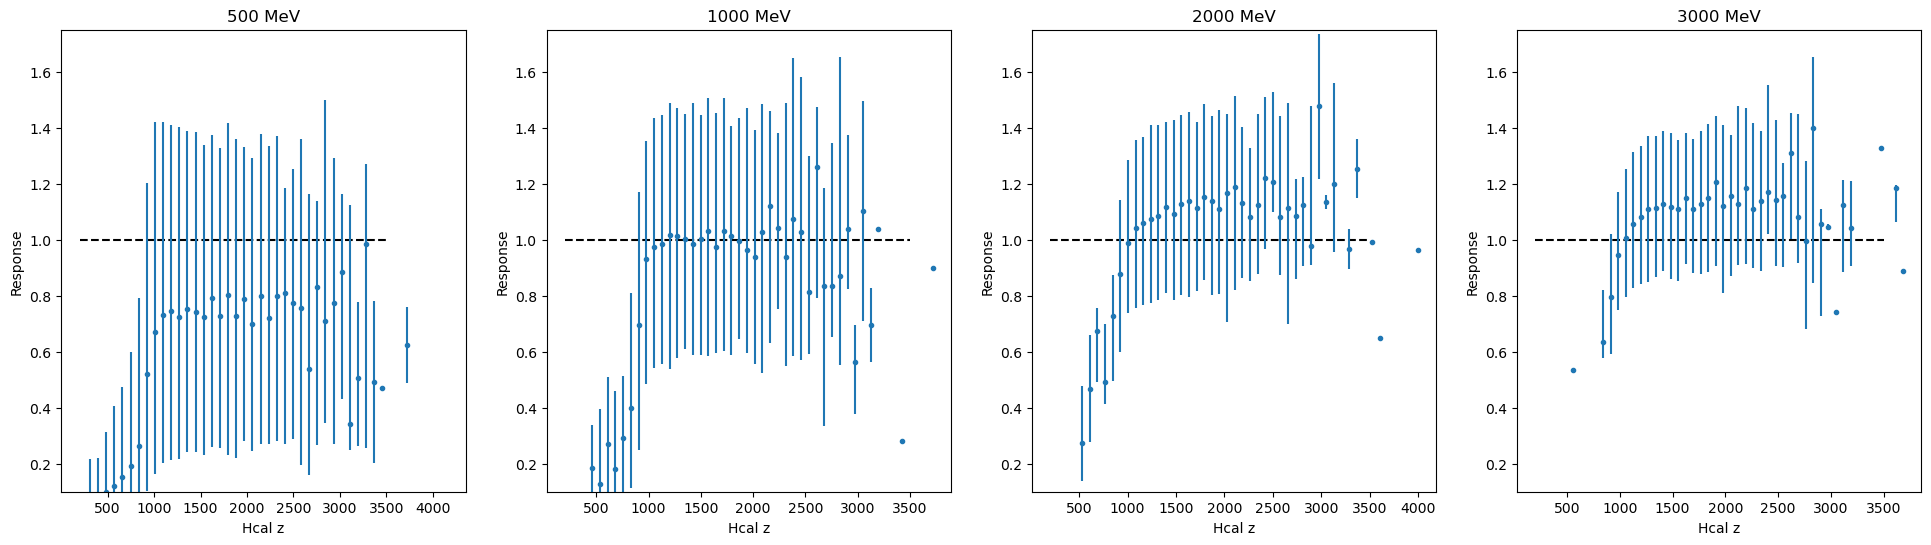

In [80]:
# output_dir = "plots"
# os.makedirs(output_dir, exist_ok=True)
Hcal_frac_distr,axs=plt.subplots(1,4,figsize=(24,6))
axs=axs.flatten()
for i,energy in enumerate(energies):
    plotProfile(Hcal_z_clean[energy],R_clean_Hcal[energy], name=f"profile_Hcal_E_{energy}",ax=axs[i],xtitle="Hcal z",ytitle="Response",nbins=45,text="R vs Hcal z")
    axs[i].set_title(f"{energy} MeV")
    axs[i].set_ylim(0.1,1.75)    
    


### response vs Ecal z

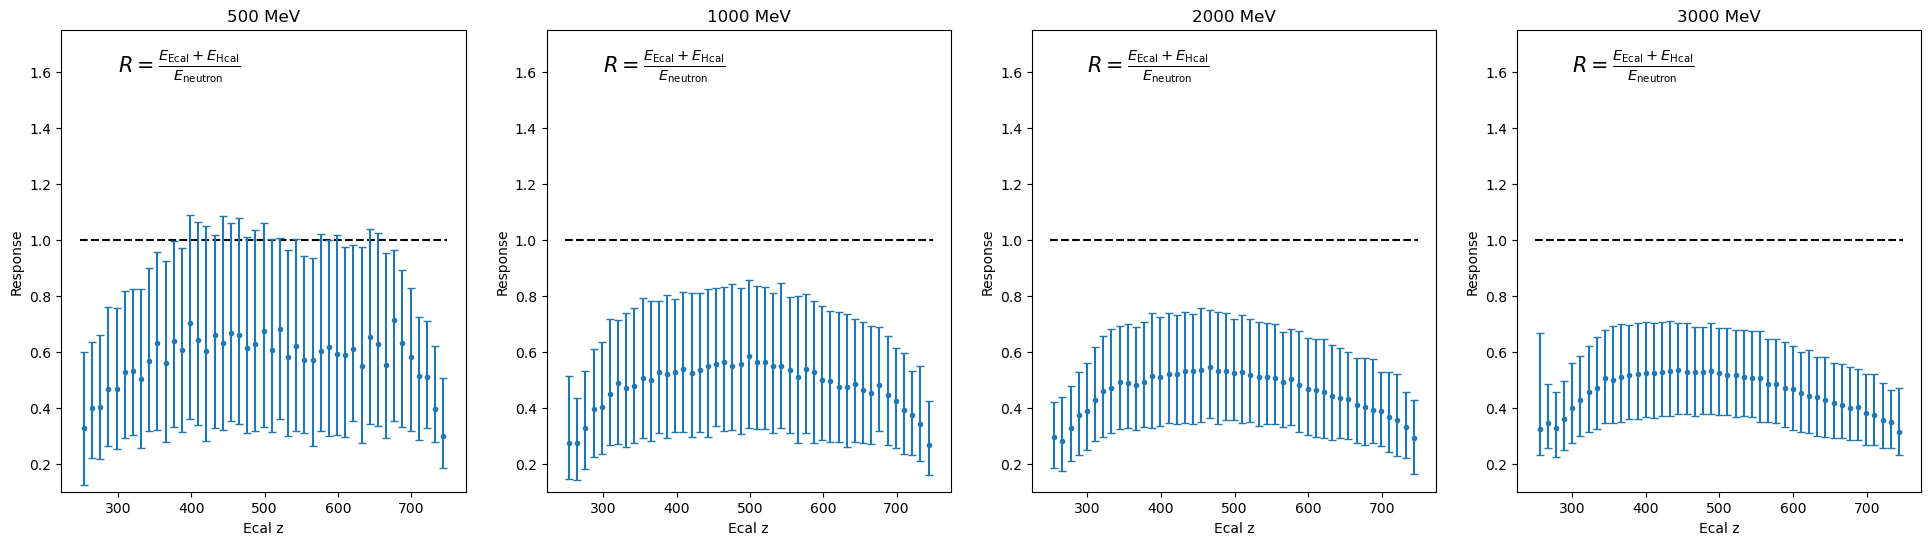

In [38]:
# output_dir = "plots"
# os.makedirs(output_dir, exist_ok=True)
Ecal_frac_distr,axs=plt.subplots(1,4,figsize=(24,6))
axs=axs.flatten()
for i,energy in enumerate(energies):
    plotProfile(Ecal_z_clean[energy],R_clean_Ecal[energy], name=f"profilEcal_E_{energy}",ax=axs[i],xtitle="Ecal z",ytitle="Response",nbins=45,text="R vs Ecal z")
    axs[i].text(300, 1.6,r"$R = \frac{E_{\mathrm{Ecal}} + E_{\mathrm{Hcal}}}{E_{\mathrm{neutron}}}$",fontsize=15)
    axs[i].set_title(f"{energy} MeV")
    axs[i].set_ylim(0.1,1.75)    
    



### Response vs Hcal z density plot

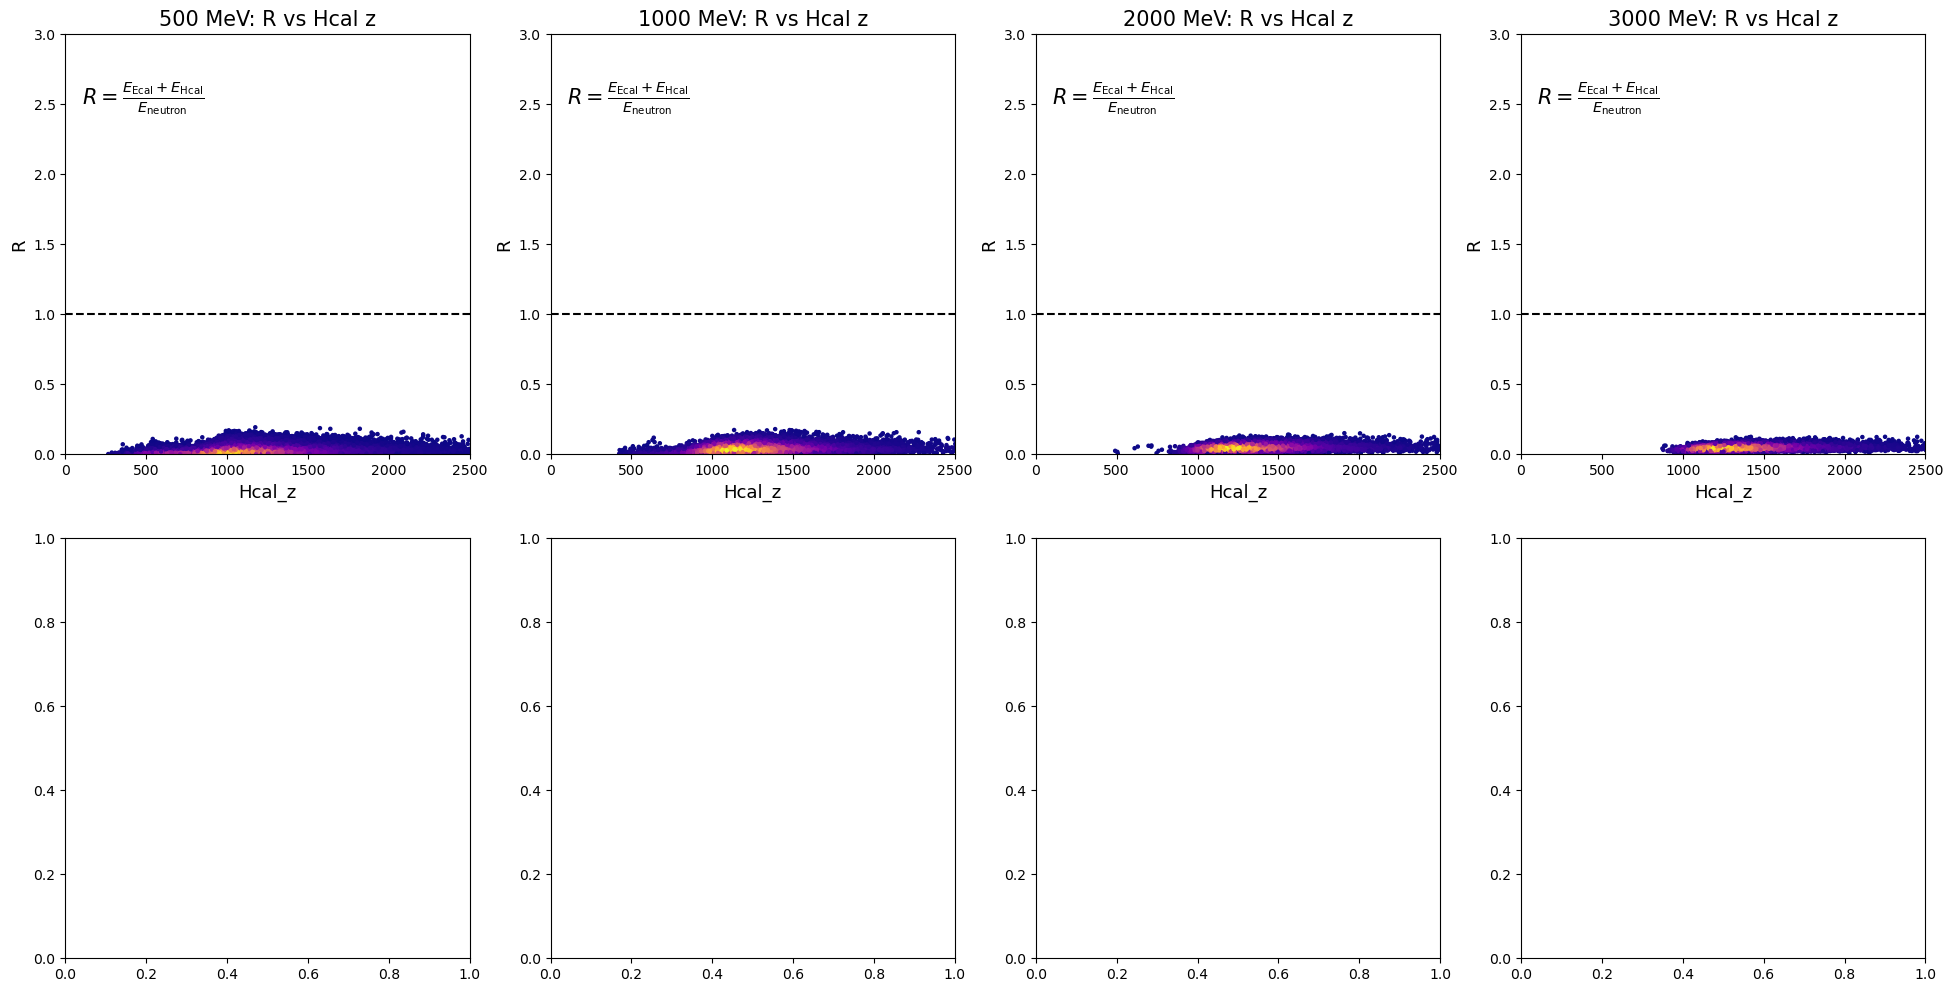

In [122]:

Hcal_frac_distr,axs=plt.subplots(2,4,figsize=(24,12))
axs=axs.flatten()
for i,energy in enumerate(energies):
    # nan_mask=~np.isnan(ak.to_numpy(Hcal_z_Ecalclean[energy]))&~np.isnan(ak.to_numpy(R_clean_Ecal[energy]))
    # Hcal_z_notnan=Hcal_z_Ecalclean[energy][nan_mask]
    # R_notnan=R_clean_Ecal[energy][nan_mask]
    
    xy=np.vstack([Hcal_z_clean[energy],R_clean_Hcal[energy]])
    z=gaussian_kde(xy)(xy)
    sc=axs[i].scatter(Hcal_z_clean[energy],R_clean_Hcal[energy],c=z,s=5,cmap="plasma")
    axs[i].plot(np.linspace(0,2500,100),np.linspace(1,1,100),"--",color="black")
    axs[i].text(100, 2.5,r"$R = \frac{E_{\mathrm{Ecal}} + E_{\mathrm{Hcal}}}{E_{\mathrm{neutron}}}$",fontsize=15)
    axs[i].set_title(f'{energy} MeV: R vs Hcal z',fontsize=15)
    axs[i].set_xlabel("Hcal_z",fontsize=13)
    axs[i].set_ylabel('R',fontsize=13)
    axs[i].set_ylim(0,3)
    axs[i].set_xlim(0,2500)


### response vs Ecal z population plot

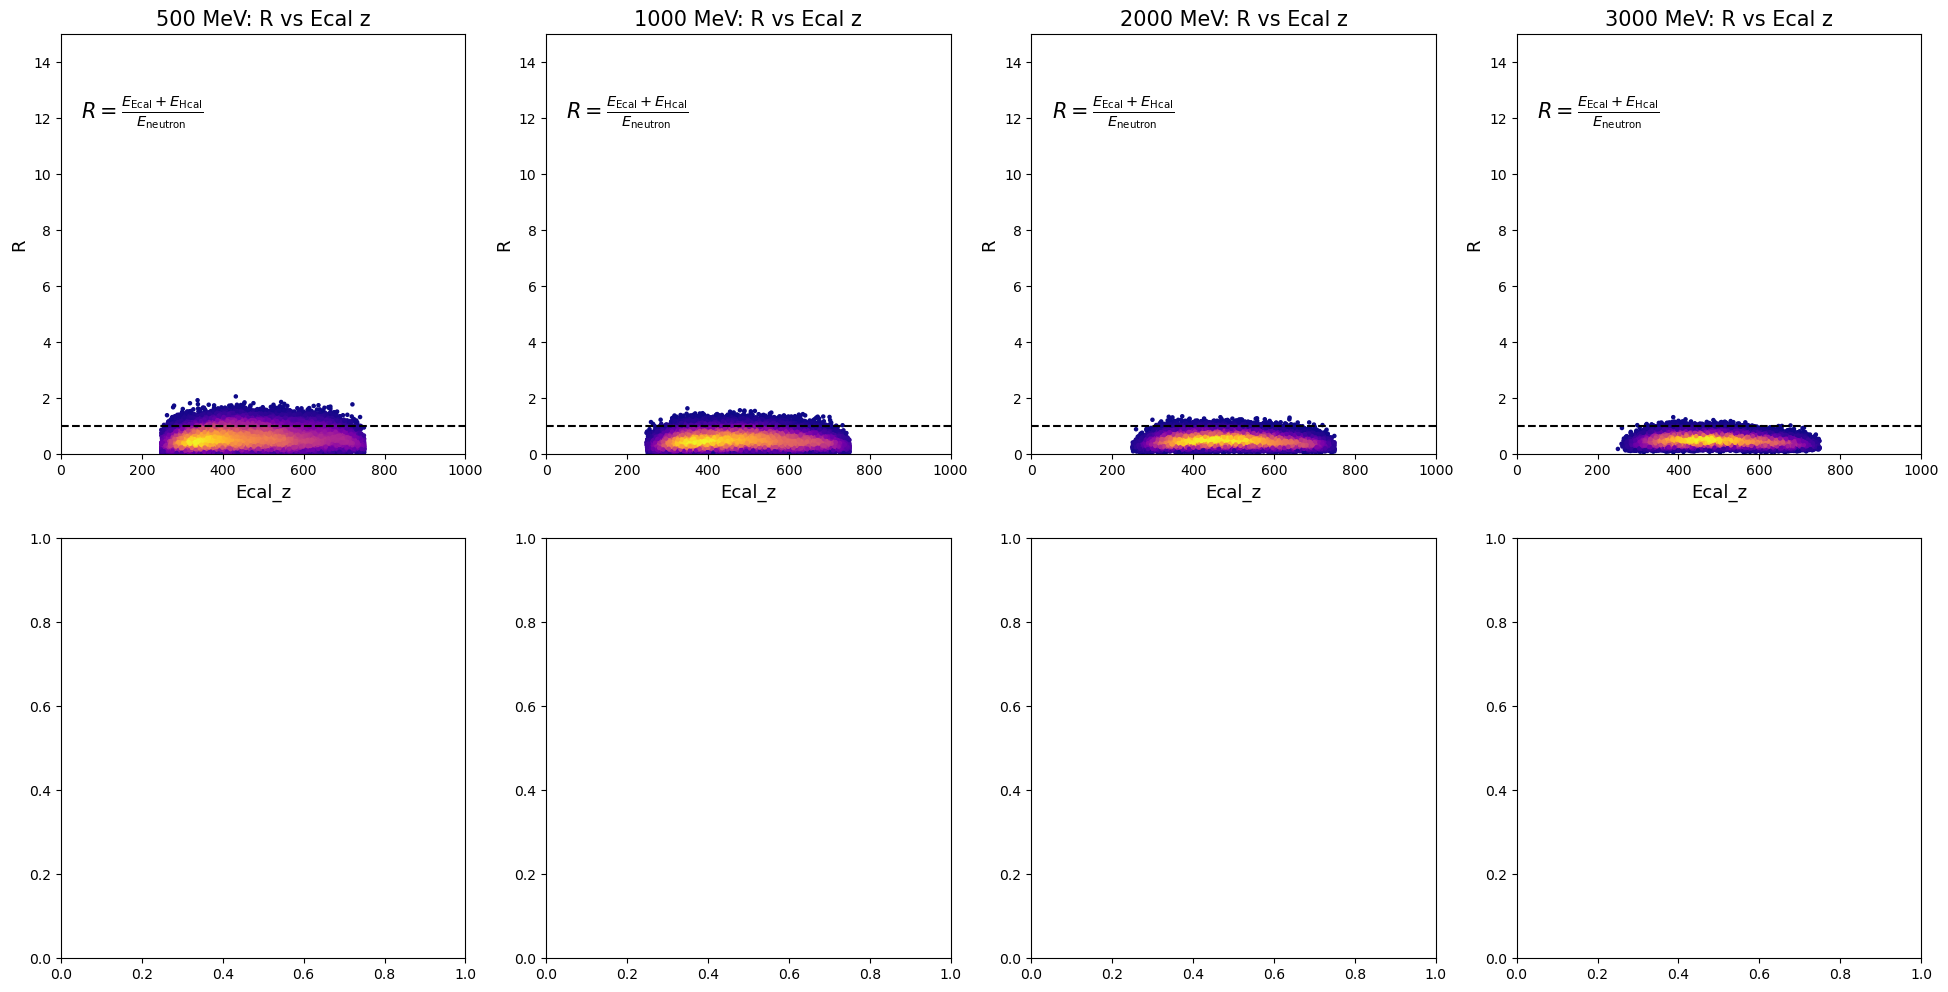

In [39]:

Ecal_frac_distr,axs=plt.subplots(2,4,figsize=(24,12))
axs=axs.flatten()
for i,energy in enumerate(energies):
    xy=np.vstack([Ecal_z_clean[energy],R_clean_Ecal[energy]])
    z=gaussian_kde(xy)(xy)
    sc=axs[i].scatter(Ecal_z_clean[energy],R_clean_Ecal[energy],c=z,s=5,cmap="plasma")
    axs[i].plot(np.linspace(0,1000,100),np.linspace(1,1,100),"--",color="black")
    axs[i].text(50, 12,r"$R = \frac{E_{\mathrm{Ecal}} + E_{\mathrm{Hcal}}}{E_{\mathrm{neutron}}}$",fontsize=15)
    axs[i].set_title(f'{energy} MeV: R vs Ecal z',fontsize=15)
    axs[i].set_xlabel("Ecal_z",fontsize=13)
    axs[i].set_ylabel('R',fontsize=13)
    axs[i].set_ylim(0,15)
    axs[i].set_xlim(0,1000)


### response vs Hcal σz

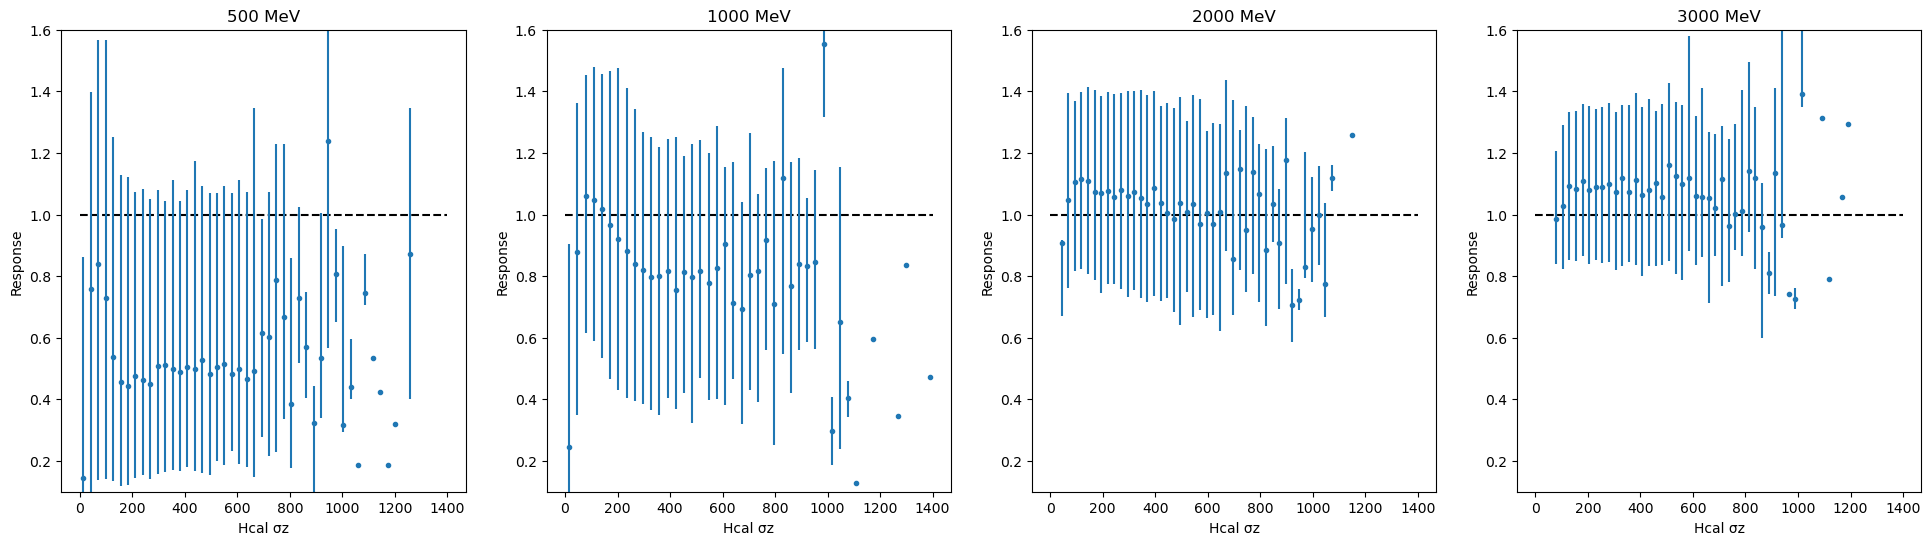

In [99]:
# output_dir = "plots"
# os.makedirs(output_dir, exist_ok=True)
cal_frac_distr,axs=plt.subplots(1,4,figsize=(24,6))
axs=axs.flatten()
Hcal_sigma_z={}
R_Hcal={}
for i,energy in enumerate(energies):
    nan_mask=~np.isnan(ak.to_numpy(Hcal_sigma_z_clean[energy]))&~np.isnan(ak.to_numpy(R_clean_Hcal[energy]))
    Hcal_sigma_z[i]=np.array(Hcal_sigma_z_clean[energy])[nan_mask]
    R_Hcal[i]=np.array(R_clean_Hcal[energy])[nan_mask]
    plotProfile(Hcal_sigma_z[i],R_Hcal[i], name=f"profilHcal_E_{energy}",ax=axs[i],xtitle="Hcal σz",ytitle="Response",nbins=45,text="R vs Hcal σz")
    axs[i].set_title(f"{energy} MeV")
    axs[i].set_ylim(0,800)
    axs[i].set_ylim(0.1,1.6)    
    



### response vs Ecal σz

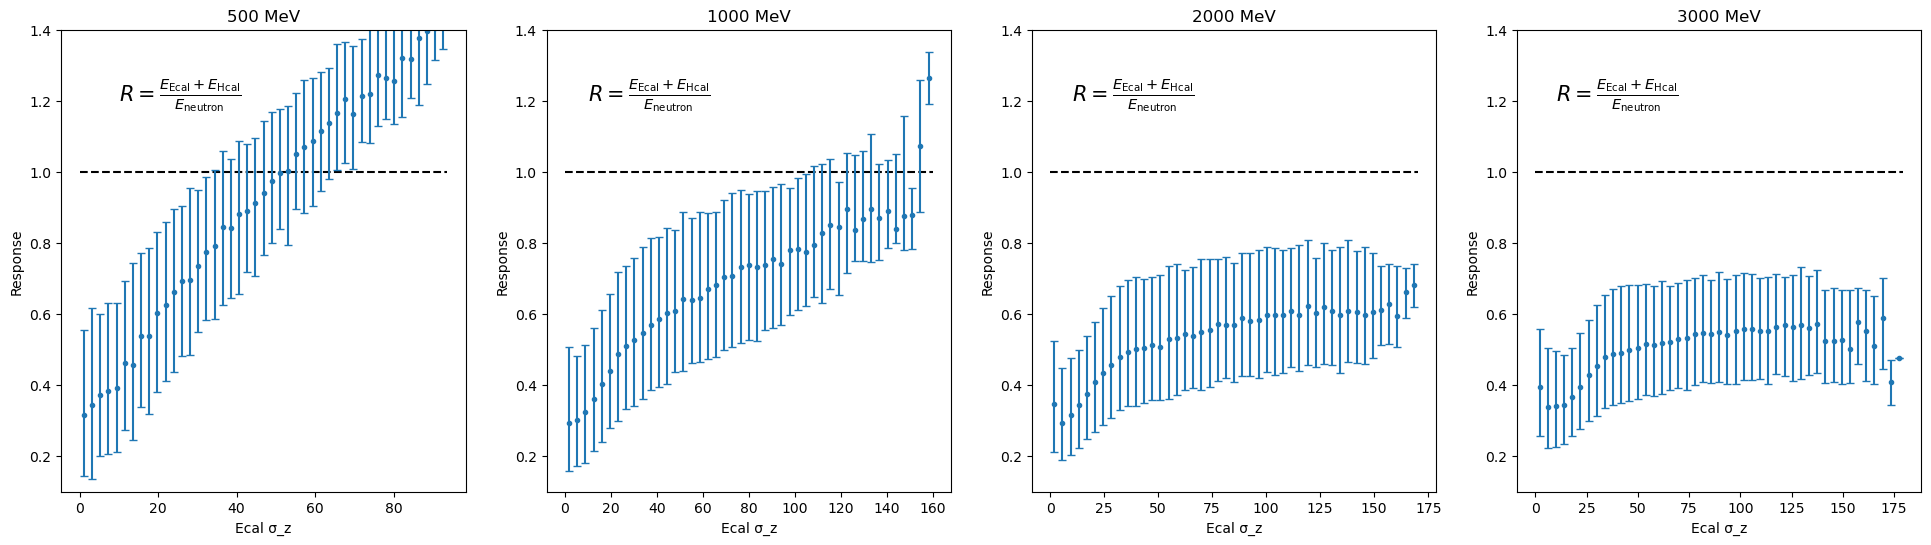

In [40]:
# output_dir = "plots"
# os.makedirs(output_dir, exist_ok=True)
Hcal_frac_distr,axs=plt.subplots(1,4,figsize=(24,6))
axs=axs.flatten()
Ecal_sigma_z={}
R_Ecal={}
for i,energy in enumerate(energies):
    nan_mask=~np.isnan(ak.to_numpy(Ecal_sigma_z_clean[energy]))&~np.isnan(ak.to_numpy(R_clean_Ecal[energy]))
    Ecal_sigma_z[i]=np.array(Ecal_sigma_z_clean[energy])[nan_mask]
    R_Ecal[i]=np.array(R_clean_Ecal[energy])[nan_mask]
    plotProfile(Ecal_sigma_z[i],R_Ecal[i], name=f"profilEcal_E_{energy}",ax=axs[i],xtitle="Ecal σ_z",ytitle="Response",nbins=45,text="R vs Ecal σz")
    axs[i].set_title(f"{energy} MeV")
    axs[i].text(10, 1.2,r"$R = \frac{E_{\mathrm{Ecal}} + E_{\mathrm{Hcal}}}{E_{\mathrm{neutron}}}$",fontsize=15)

    axs[i].set_ylim(0.1,1.4)    
    



### response vs Ecal E

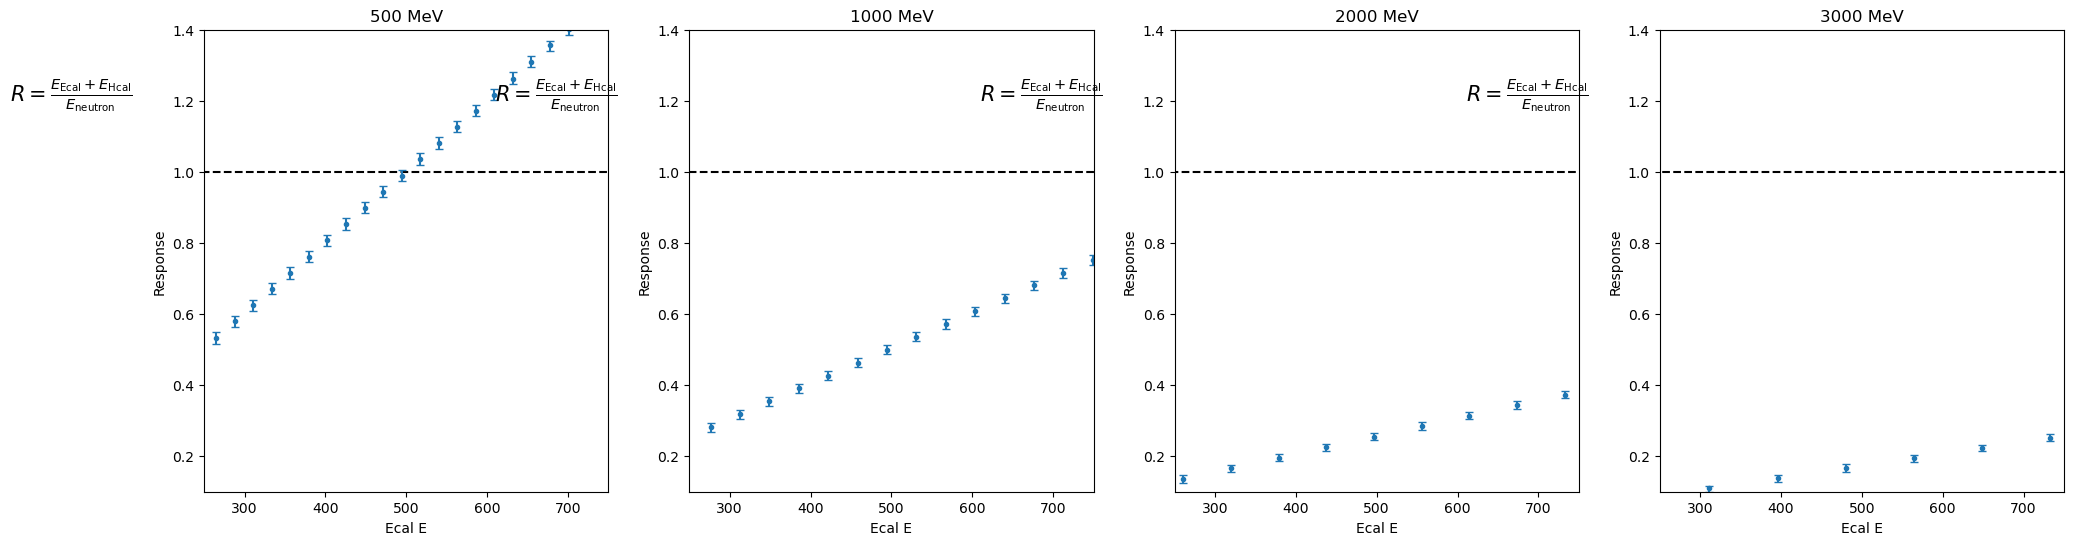

In [44]:
# output_dir = "plots"
# os.makedirs(output_dir, exist_ok=True)
Hcal_frac_distr,axs=plt.subplots(1,4,figsize=(24,6))
axs=axs.flatten()
Ecal_sigma_z={}
R_Ecal={}
for i,energy in enumerate(energies):
    nan_mask=~np.isnan(ak.to_numpy(Ecal_E_clean[energy]))&~np.isnan(ak.to_numpy(R_clean_Ecal[energy]))
    Ecal_E[i]=np.array(Ecal_E_clean[energy])[nan_mask]
    R_Ecal[i]=np.array(R_clean_Ecal[energy])[nan_mask]
    plotProfile(Ecal_E[i],R_Ecal[i], name=f"profilEcal_E_{energy}",ax=axs[i],xtitle="Ecal E",ytitle="Response",nbins=45,text="R vs Ecal E")
    axs[i].set_title(f"{energy} MeV")
    axs[i].text(10, 1.2,r"$R = \frac{E_{\mathrm{Ecal}} + E_{\mathrm{Hcal}}}{E_{\mathrm{neutron}}}$",fontsize=15)
    axs[i].set_xlim(250,750) 
    axs[i].set_ylim(0.1,1.4)    
    



### response vs Hcal σt

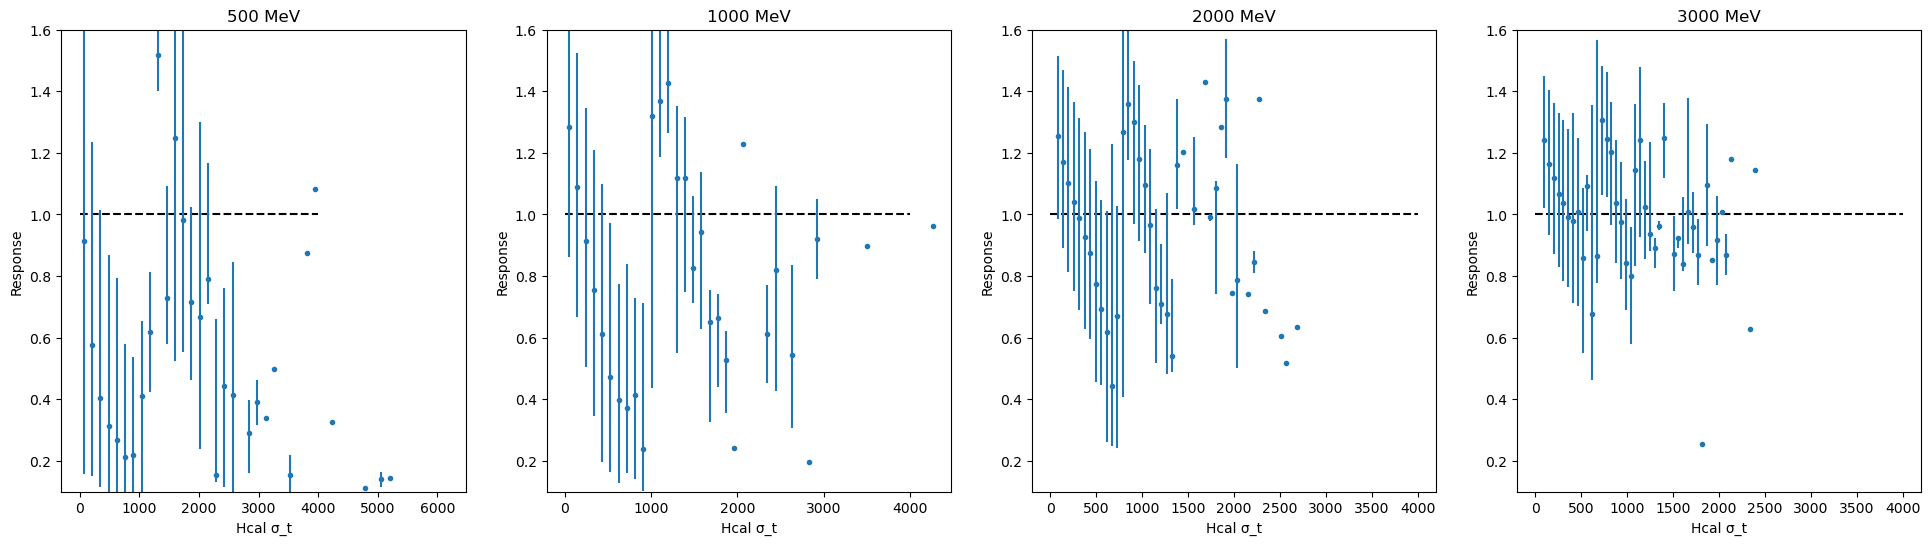

In [107]:
# output_dir = "plots"
# os.makedirs(output_dir, exist_ok=True)
cal_frac_distr,axs=plt.subplots(1,4,figsize=(24,6))
axs=axs.flatten()
Hcal_sigma_t={}
R_Hcal={}
for i,energy in enumerate(energies):
    nan_mask=~np.isnan(ak.to_numpy(Hcal_sigma_t_clean[energy]))&~np.isnan(ak.to_numpy(R_clean_Hcal[energy]))
    Hcal_sigma_t[i]=np.array(Hcal_sigma_t_clean[energy])[nan_mask]
    R_Hcal[i]=np.array(R_clean_Hcal[energy])[nan_mask]
    plotProfile(Hcal_sigma_t[i],R_Hcal[i], name=f"profilHcal_E_{energy}",ax=axs[i],xtitle="Hcal σ_t",ytitle="Response",nbins=45,text="R vs Hcal σ_t")
    axs[i].set_title(f"{energy} MeV")

    axs[i].set_ylim(0.1,1.6)    
    



### response vs Ecal σt

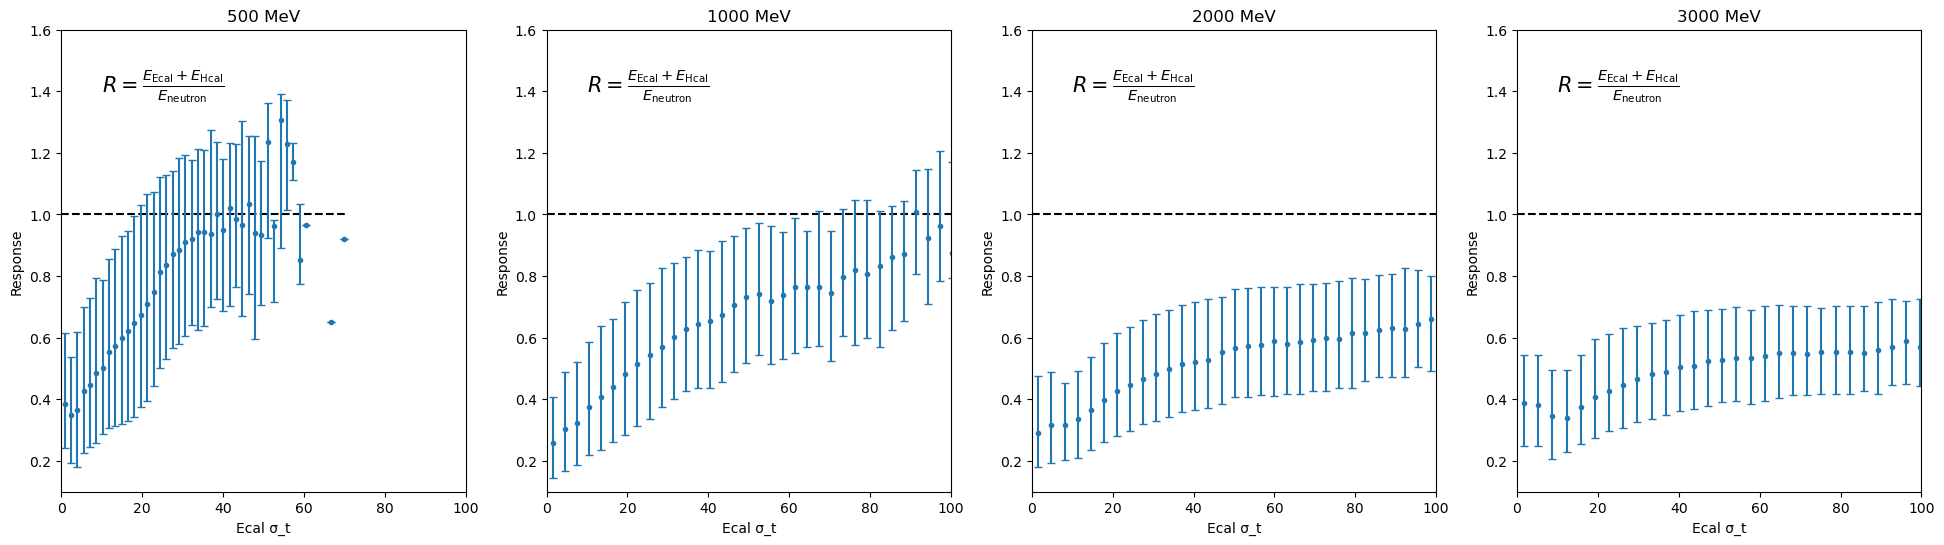

In [41]:
# output_dir = "plots"
# os.makedirs(output_dir, exist_ok=True)
cal_frac_distr,axs=plt.subplots(1,4,figsize=(24,6))
axs=axs.flatten()
Ecal_sigma_t={}
R_Ecal={}
for i,energy in enumerate(energies):
    nan_mask=~np.isnan(ak.to_numpy(Ecal_sigma_t_clean[energy]))&~np.isnan(ak.to_numpy(R_clean_Ecal[energy]))
    Ecal_sigma_t[i]=np.array(Ecal_sigma_t_clean[energy])[nan_mask]
    R_Ecal[i]=np.array(R_clean_Ecal[energy])[nan_mask]
    plotProfile(Ecal_sigma_t[i],R_Ecal[i], name=f"profilEcal_E_{energy}",ax=axs[i],xtitle="Ecal σ_t",ytitle="Response",nbins=45,text="R vs Ecal σ_t")
    axs[i].text(10, 1.4,r"$R = \frac{E_{\mathrm{Ecal}} + E_{\mathrm{Hcal}}}{E_{\mathrm{neutron}}}$",fontsize=15)

    axs[i].set_title(f"{energy} MeV")
    axs[i].set_xlim(0,100)  
    axs[i].set_ylim(0.1,1.6)    
    



# NN stuff

### $\color{red}{\text{defining early stopping function}}$

In [45]:
patience = 50  # epochs to wait after no improvement
delta = 2.5e-6  # minimum change in the monitored metric
best_val_loss = float("inf")  # best validation loss to compare against
no_improvement_count = 0 

class EarlyStopping:
    def __init__(self, patience, delta, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
    
    def check_early_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
               

# Initialize early stopping

#### running the 2D NN model (one model per neutron gun energy)

In [46]:
import torch
import torch.nn as nn
import math
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


start = time.time()
dtype = torch.float
device = torch.device("cpu")

z_val={}
E_val={}
R_val={}
O_pred={}   #predicted output
a={}
b={}
model={}
loss={}
iteration={}
# device = torch.device("cuda:0") # Uncomment this to run on GPU
for i,energy in enumerate(energies):
    early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True)

    z_train,z_val[i],E_train,E_val[i],R_train,R_val[i]=train_test_split(Ecal_z_clean[energy],Ecal_E_clean[energy],R_clean_Ecal[energy],test_size=0.2)


    
    # Ecal_E_tensor[energy]=torch.tensor(Ecal_E_clean[energy],dtype=torch.float).unsqueeze(1)
    # # Hcal_E_tensor[energy]=torch.tensor(Hcal_energy[energy],dtype=torch.float).unsqueeze(1)
    # Ecal_z_tensor[energy]=torch.tensor(Ecal_z_clean[energy],dtype=torch.float).unsqueeze(1)
    # z_Hcal_tensor[energy]=torch.tensor(z_Hcal[energy],dtype=torch.float).unsqueeze(1)
    # sigma_T_Ecal_tensor
    # sigma_T_Hcal
    # sigma_z_Hcal
    # sigma_z_Ecal

    
    I_train = torch.tensor(np.column_stack((z_train,E_train)), dtype=torch.float)
    O_train = torch.tensor(R_train, dtype=torch.float).unsqueeze(1)
    I_val = torch.tensor(np.column_stack((z_val[i],E_val[i])), dtype=torch.float)
    O_val = torch.tensor(R_val[i], dtype=torch.float).unsqueeze(1)
    # model[energy]=nn.Sequential(nn.Linear(8,16),
    #                             nn.ReLU(),
    #                             nn.Linear(16,32),
    #                             nn.ReLU(),
    #                             nn.Linear(32,16),
    #                             nn.ReLU(),
    #                             nn.Linear(16,1),
    #                             nn.ReLU())
   
    model[energy]=nn.Sequential(nn.Linear(2,8),     
                                nn.ReLU(),
                                nn.Linear(8,16),
                                nn.ReLU(),
                                nn.Linear(16,8),
                                nn.ReLU(),
                                nn.Linear(8,1),
                                )
    loss_fn=torch.nn.L1Loss()     
    optimizer = torch.optim.Adam(model[energy].parameters(), lr=1e-5)

    loss[energy]=[]
    iteration[energy]=[]

    for step in range(50000):
        # Forward pass: compute predicted y
        model[energy].train()
        optimizer.zero_grad(set_to_none=True)
        O_pred[energy] = model[energy](I_train)
        train_loss = loss_fn(O_pred[energy],O_train)
        train_loss.backward()
        optimizer.step()

        model[energy].eval()
        with torch.no_grad():
            O_pred_val = model[energy](I_val)
            val_loss = loss_fn(O_pred_val, O_val).item()
        loss[energy].append(train_loss.item())
        iteration[energy].append(step)
        
        prev_count = early_stopping.no_improvement_count
        # early_stopping.check_early_stop(val_loss)
        # if early_stopping.stop_training:
        #     print(f"Early stopping at iteration {step} with val_loss {val_loss:.6e}")
        #     break


        
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Elapsed time: 1345.54 seconds


### rate of convergence (loss vs epoch)

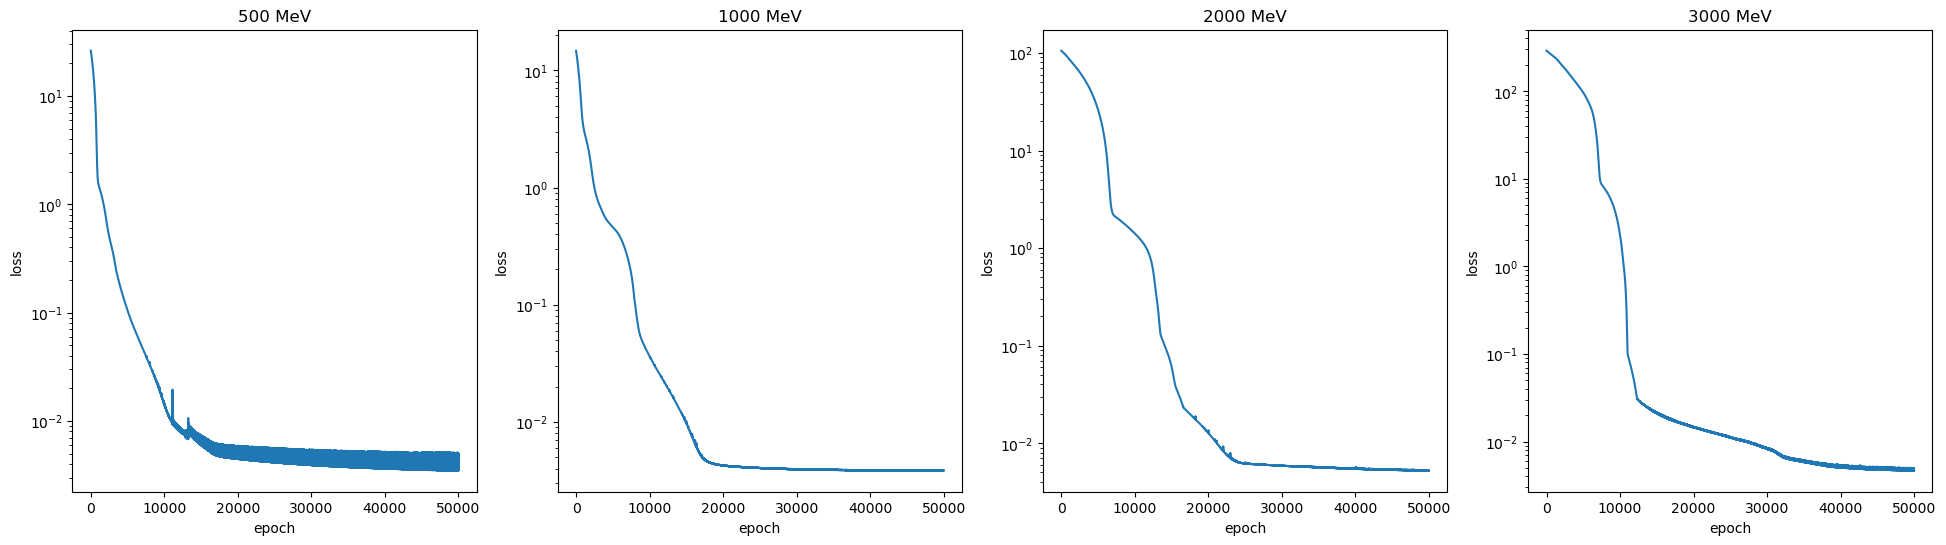

In [23]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
for i, energy in enumerate(energies):
    axs[i].plot(iteration[energy],loss[energy])
    axs[i].set_title(f"{energy} MeV")
    axs[i].set_ylabel("loss")
    axs[i].set_xlabel("epoch")
    axs[i].set_yscale("log")

#### R(z)

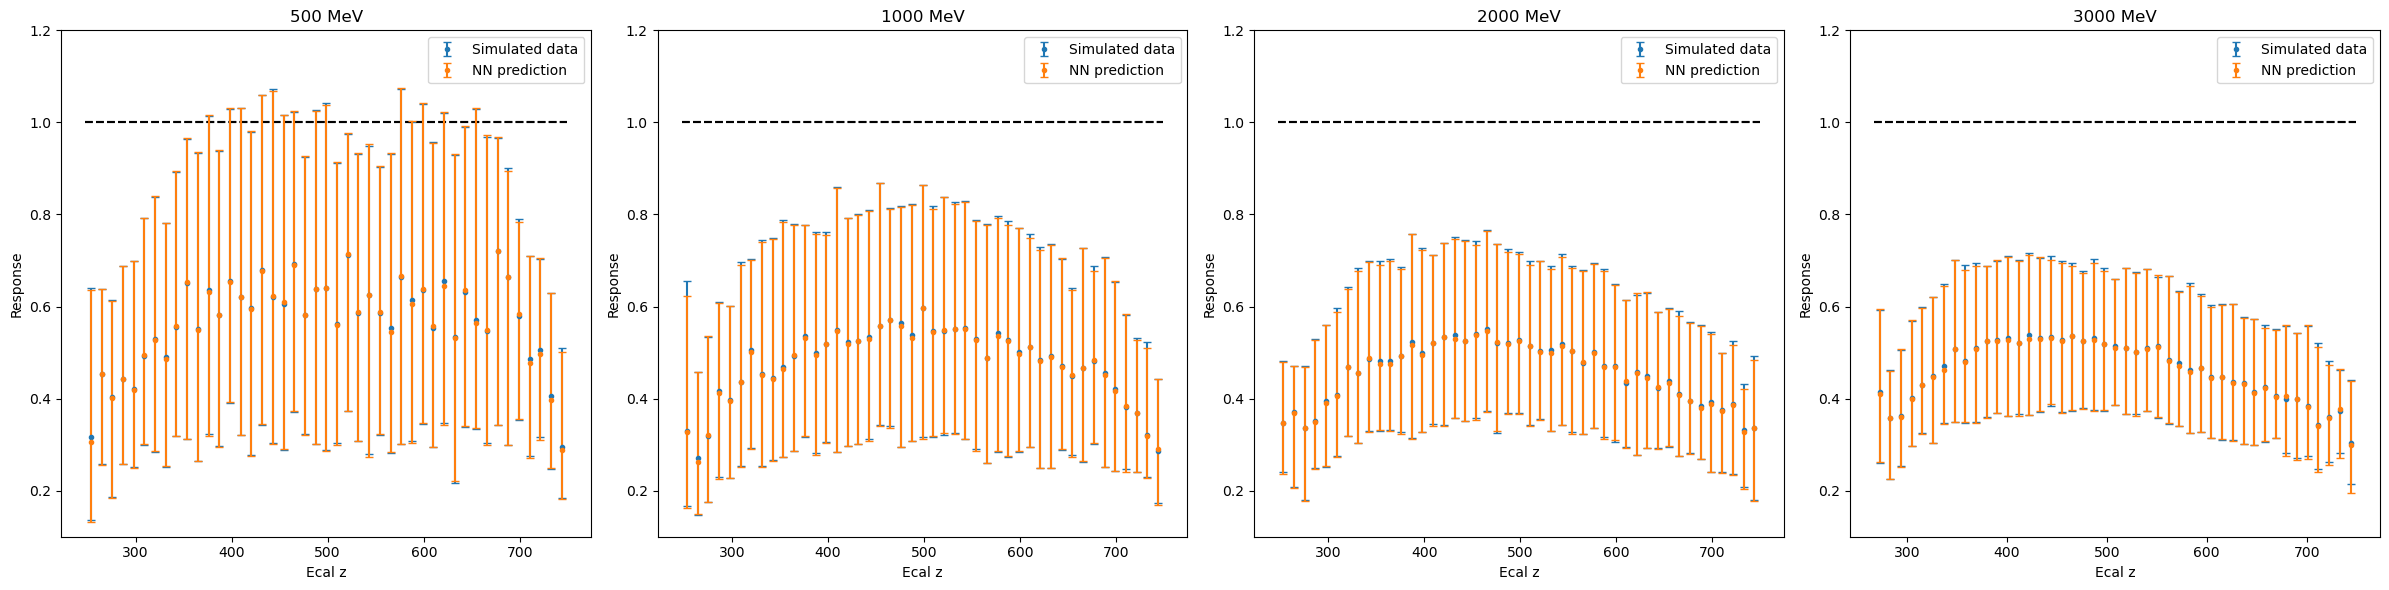

Elapsed time: 0.44 seconds


In [24]:
from scipy.stats import binned_statistic

start = time.time()
Ecal_frac_distr, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten()

for i, energy in enumerate(energies):
    # Plot the data profile first

    plotProfile(
        z_val[i],
        R_val[i],
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal z",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal z",
        leg="Simulated data"
    )

    # Generate test inputs for NN model

    # Feed to model
    I_test = torch.tensor(np.column_stack((z_val[i], E_val[i])), dtype=torch.float)
    with torch.no_grad():
        R_pred = model[energy](I_test).squeeze().numpy()
    plotProfile(
        z_val[i],
        R_pred,
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal z",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal z",
        leg="NN prediction"
    )
    
    axs[i].set_title(f"{energy} MeV")
    axs[i].set_ylim(0.1, 1.2)
    axs[i].legend()
plt.tight_layout()
plt.show()
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

#### R(z) fractional resolution comparison

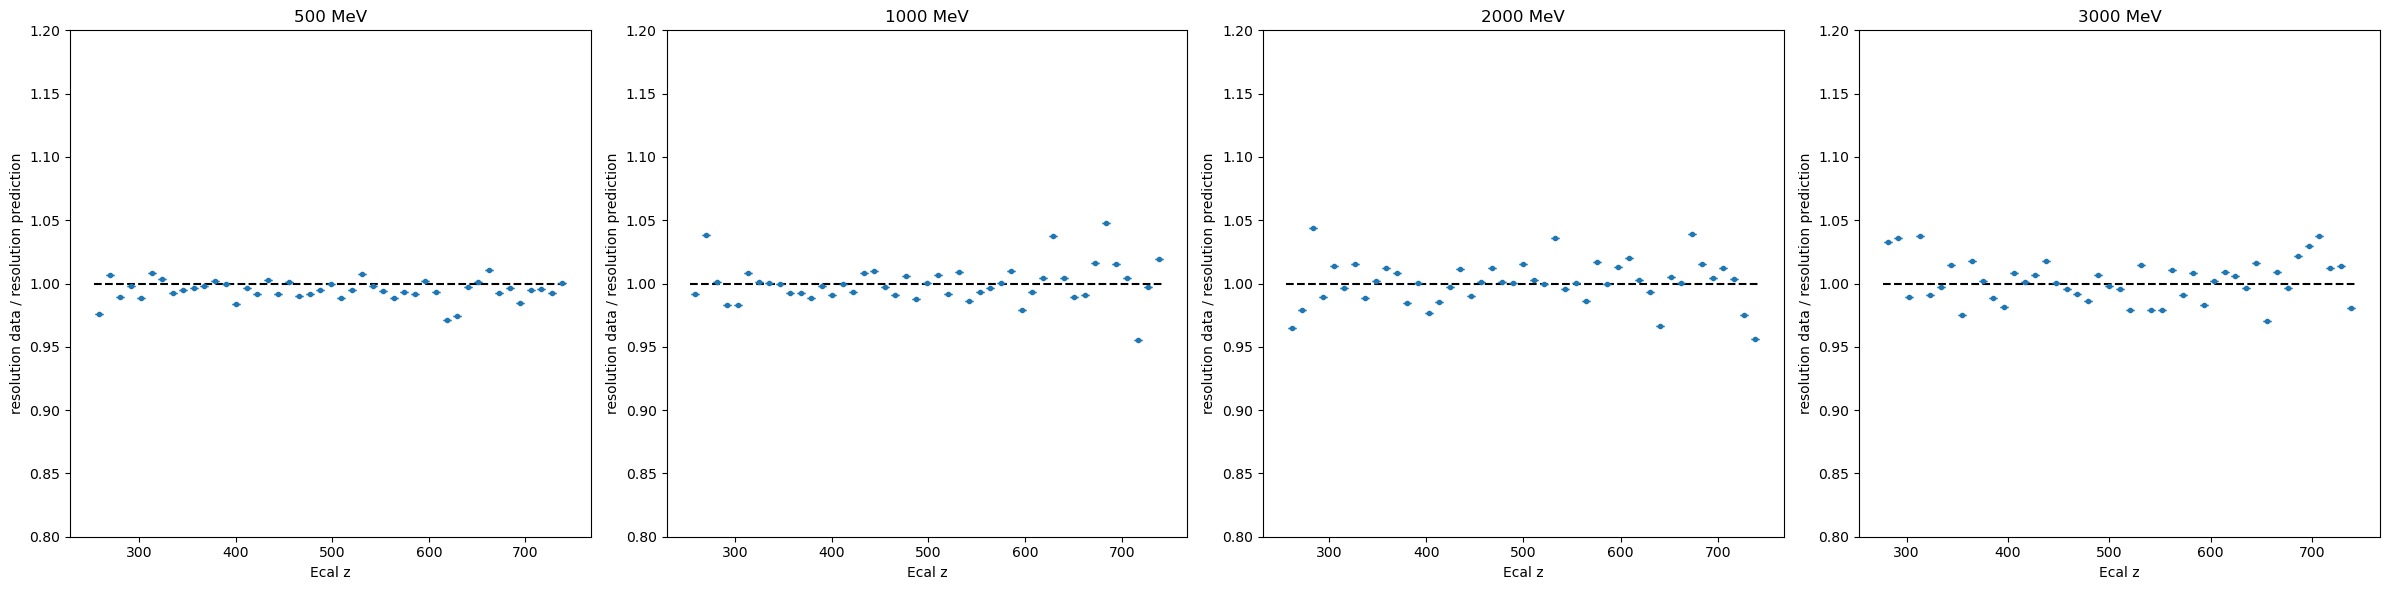

Elapsed time: 1.05 seconds


In [47]:
from scipy.stats import binned_statistic

start = time.time()
Ecal_frac_distr, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten()

for i, energy in enumerate(energies):
    # Plot the data profile first

    bin_centers, median, (loe, hie), fit=plotProfile(
        z_val[i],
        R_val[i],
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal z",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal z",
        leg="Simulated data",plot=False
    )
    res_data=(loe+hie)/median

    I_test = torch.tensor(np.column_stack((z_val[i], E_val[i])), dtype=torch.float)
    with torch.no_grad():
        R_pred = model[energy](I_test).squeeze().numpy()

    bin_centers, median, (loe, hie), fit =plotProfile(
        z_val[i],
        R_pred,
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal z",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal z",
        leg="NN prediction",plot=False
    )
    res_NN=(loe+hie)/median

    
    plotProfile(
        bin_centers,
        res_data/res_NN,
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal z",
        ytitle="resolution data / resolution prediction",
        nbins=len(median),
        text="resolution ratio vs z"
    )
    
    axs[i].set_title(f"{energy} MeV")
    axs[i].set_ylim(0.8, 1.2)
plt.tight_layout()
plt.show()
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

#### simulated data fractional resolution (z)

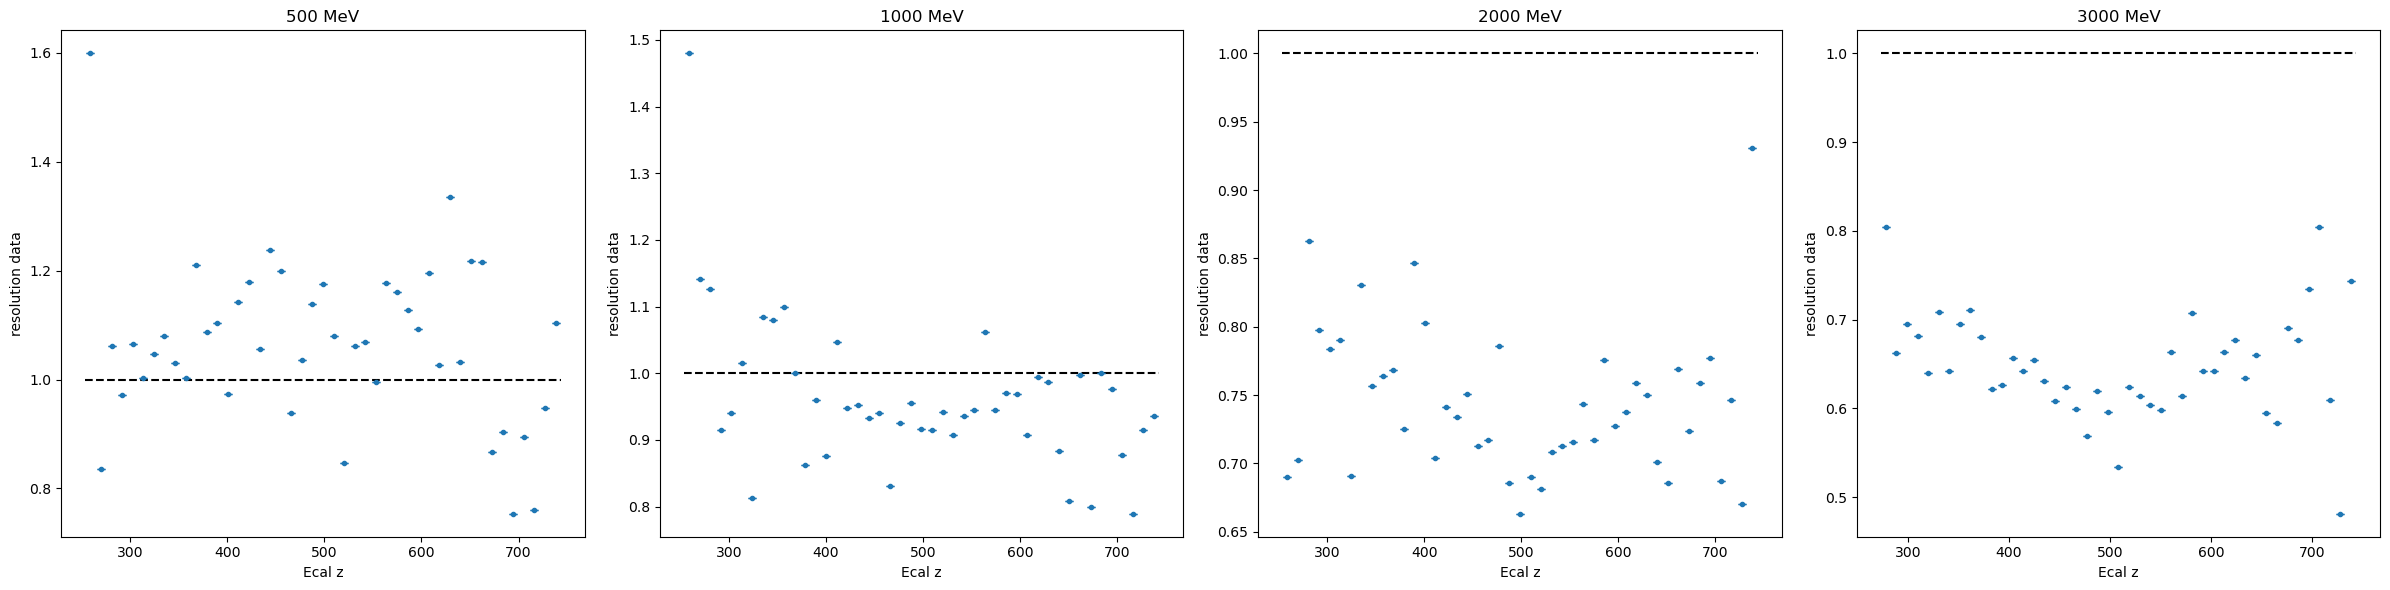

Elapsed time: 0.35 seconds


In [28]:
from scipy.stats import binned_statistic

start = time.time()
Ecal_frac_distr, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten()

for i, energy in enumerate(energies):
    # Plot the data profile first

    bin_centers, median, (loe, hie), fit=plotProfile(
        z_val[i],
        R_val[i],
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal z",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal z",
        leg="Simulated data",plot=False
    )
    res_data=(loe+hie)/median

    I_test = torch.tensor(np.column_stack((z_val[i], E_val[i])), dtype=torch.float)
    with torch.no_grad():
        R_pred = model[energy](I_test).squeeze().numpy()

    
    plotProfile(
        bin_centers,
        res_data,
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal z",
        ytitle="resolution data",
        nbins=len(median),
        text="resolution vs z"
    )
    
    axs[i].set_title(f"{energy} MeV")
plt.tight_layout()
plt.show()
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

#### NN fractional resolution (z)

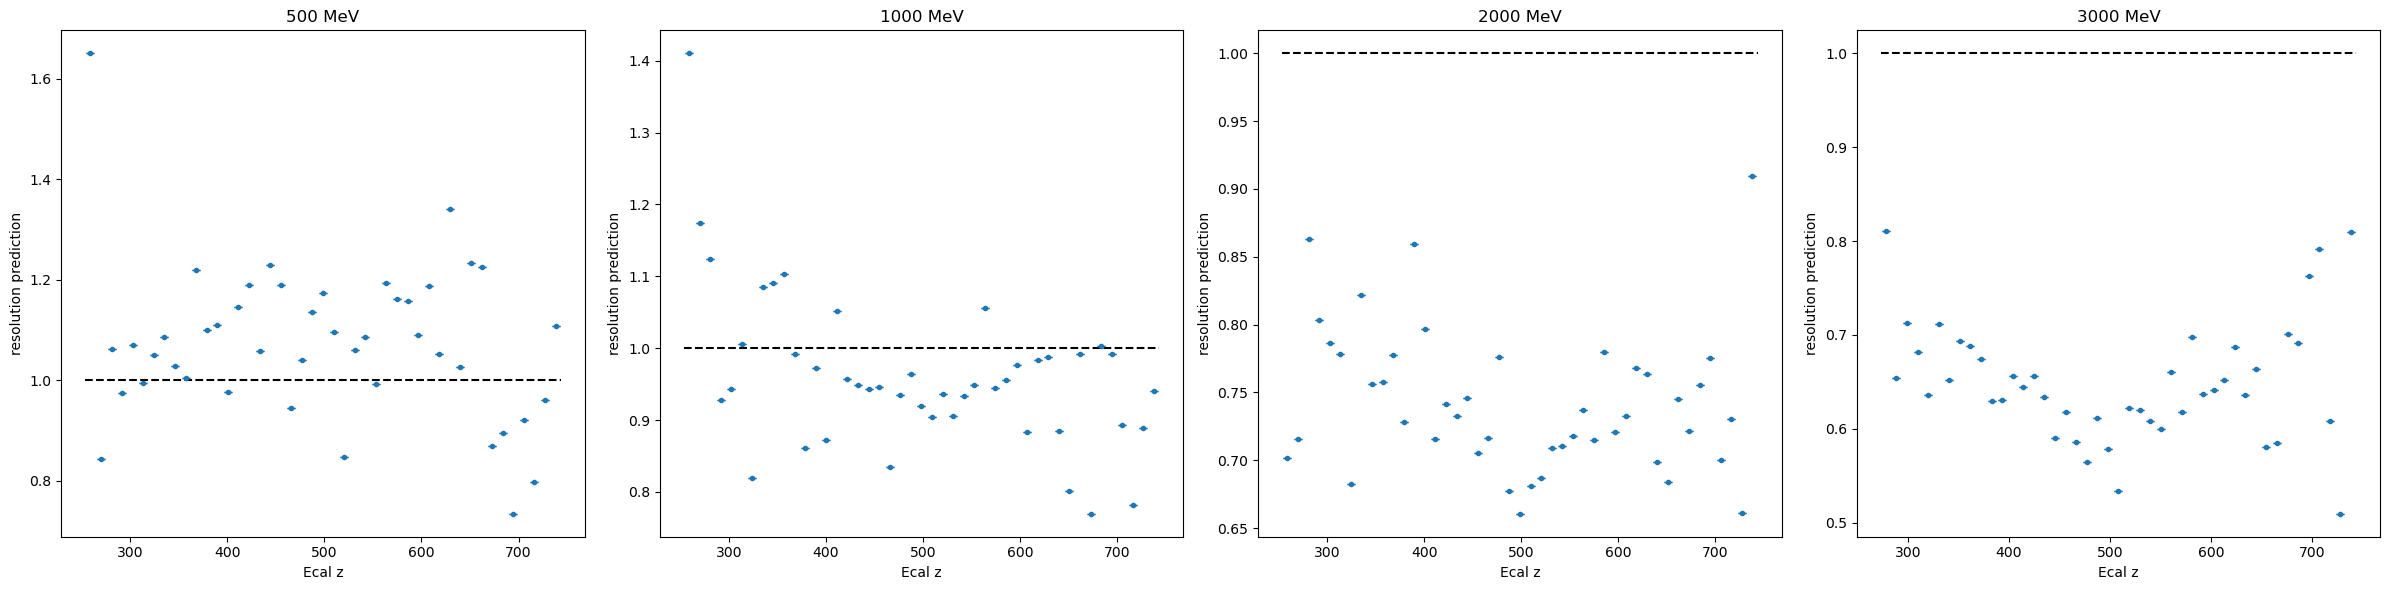

Elapsed time: 0.42 seconds


In [33]:
from scipy.stats import binned_statistic

start = time.time()
Ecal_frac_distr, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten()

for i, energy in enumerate(energies):
    # Plot the data profile first

    I_test = torch.tensor(np.column_stack((z_val[i], E_val[i])), dtype=torch.float)
    with torch.no_grad():
        R_pred = model[energy](I_test).squeeze().numpy()

    bin_centers, median, (loe, hie), fit =plotProfile(
        z_val[i],
        R_pred,
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal z",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal z",
        leg="NN prediction",plot=False
    )
    res_NN=(loe+hie)/median

    
    plotProfile(
        bin_centers,
        res_NN,
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal z",
        ytitle="resolution prediction",
        nbins=len(median),
        text="resolution ratio vs z"
    )
    
    axs[i].set_title(f"{energy} MeV")
plt.tight_layout()
plt.show()
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

#### R_data/R_NN (z)

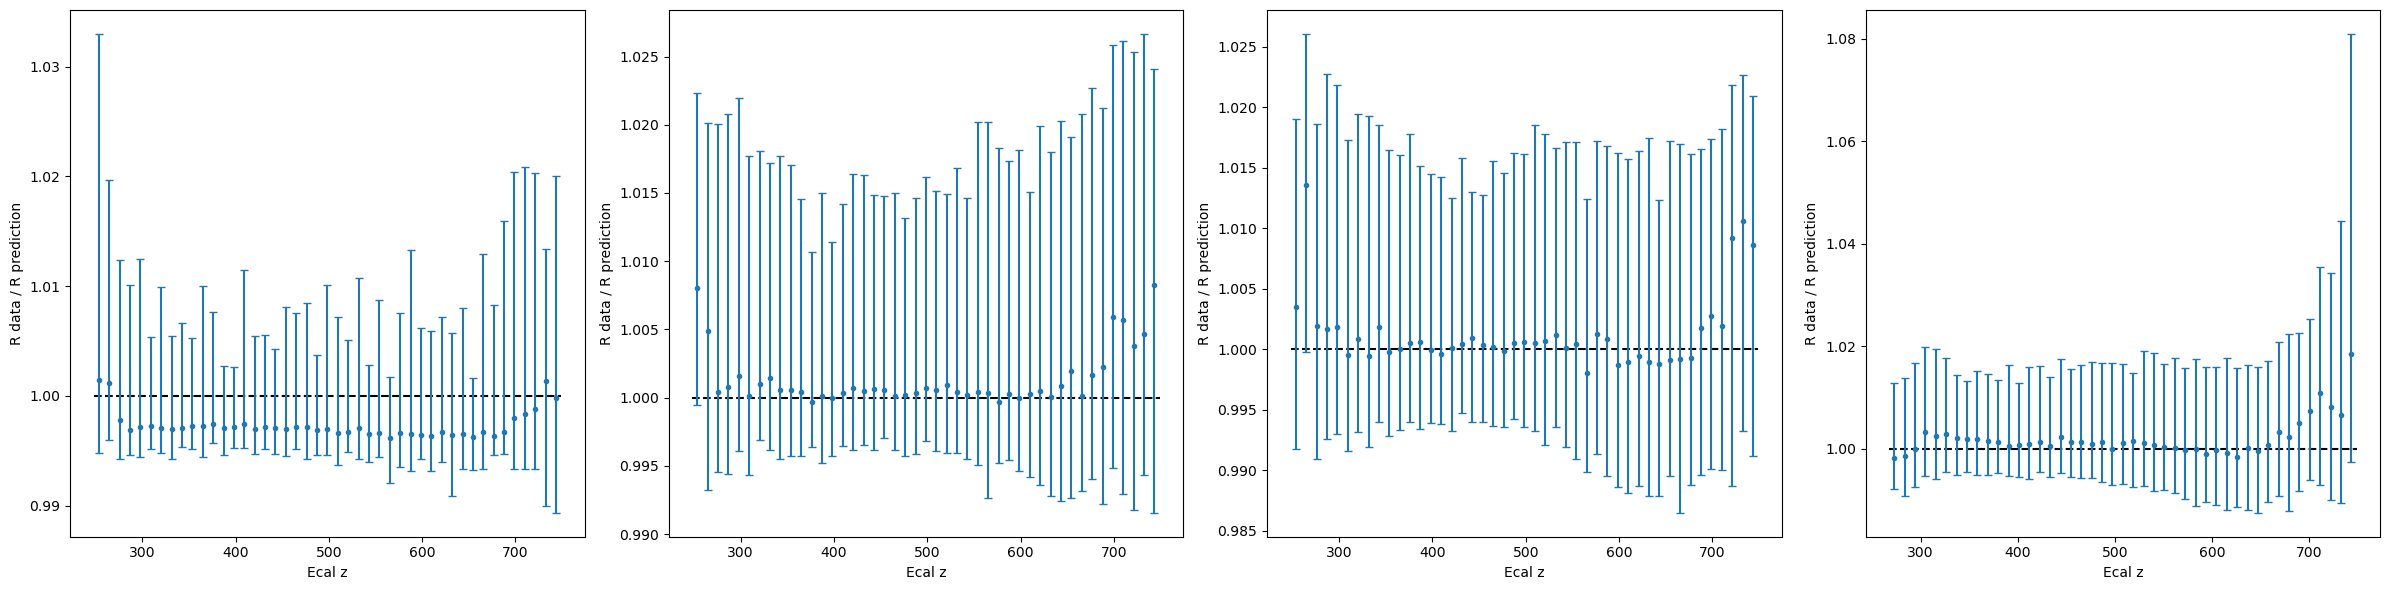

In [34]:
ratio={}
Ecal_frac_distr, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten()

for i, energy in enumerate(energies):

    # Feed to model
    I_test = torch.tensor(np.column_stack((z_val[i], E_val[i])), dtype=torch.float)
    with torch.no_grad():
        R_pred = model[energy](I_test).squeeze().numpy()
    
    ratio[energy]=R_val[i]/R_pred

    plotProfile(
        z_val[i],
        ratio[energy],
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal z",
        ytitle="R data / R prediction",
        nbins=45,
        text="R ratio vs z"
    )
    # axs[i].set_ylim(0.6, 1.4)


plt.tight_layout()
plt.show()

#### E_neutron_NN_pred(z)

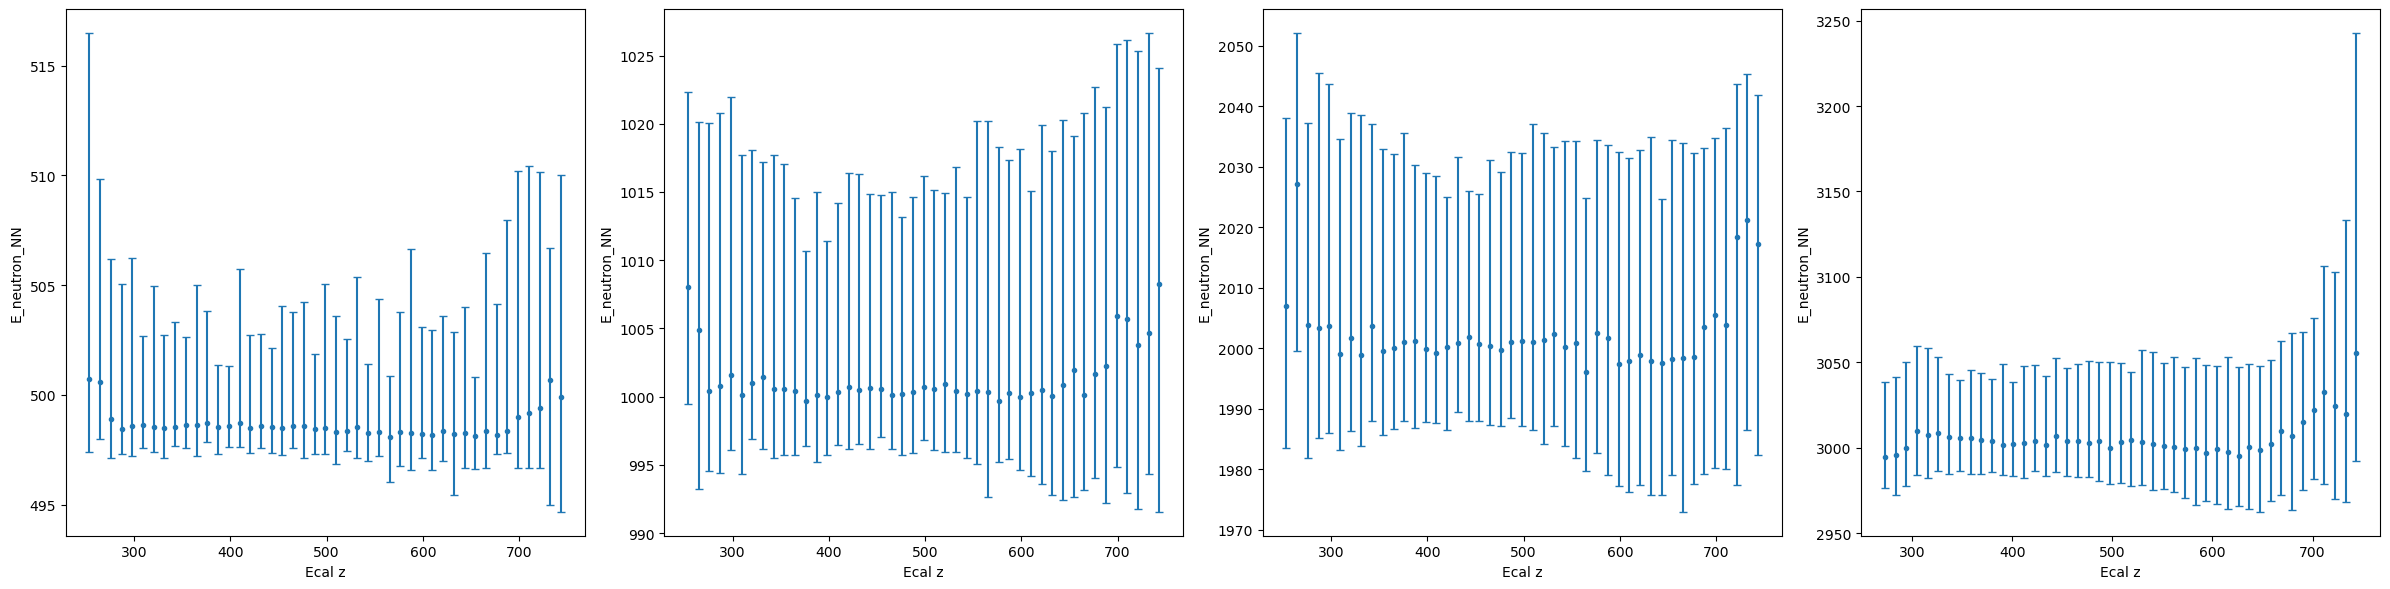

In [35]:
Ecal_frac_distr, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten()
E_neutron_pred={}
for i, energy in enumerate(energies):
    
    # Feed to model
    I_test = torch.tensor(np.column_stack((z_val[i], E_val[i])), dtype=torch.float)
    with torch.no_grad():
        R_pred = model[energy](I_test).squeeze().numpy()
     
    E_neutron_pred[energy]=R_val[i]*energy/R_pred

    plotProfile(
        z_val[i],
        E_neutron_pred[energy],
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal z",
        ytitle="E_neutron_NN",
        nbins=45,
        text="predicted neutron energy vs z",
        show_y1=False
    )


plt.tight_layout()
plt.show()

#### R(E_Ecal)

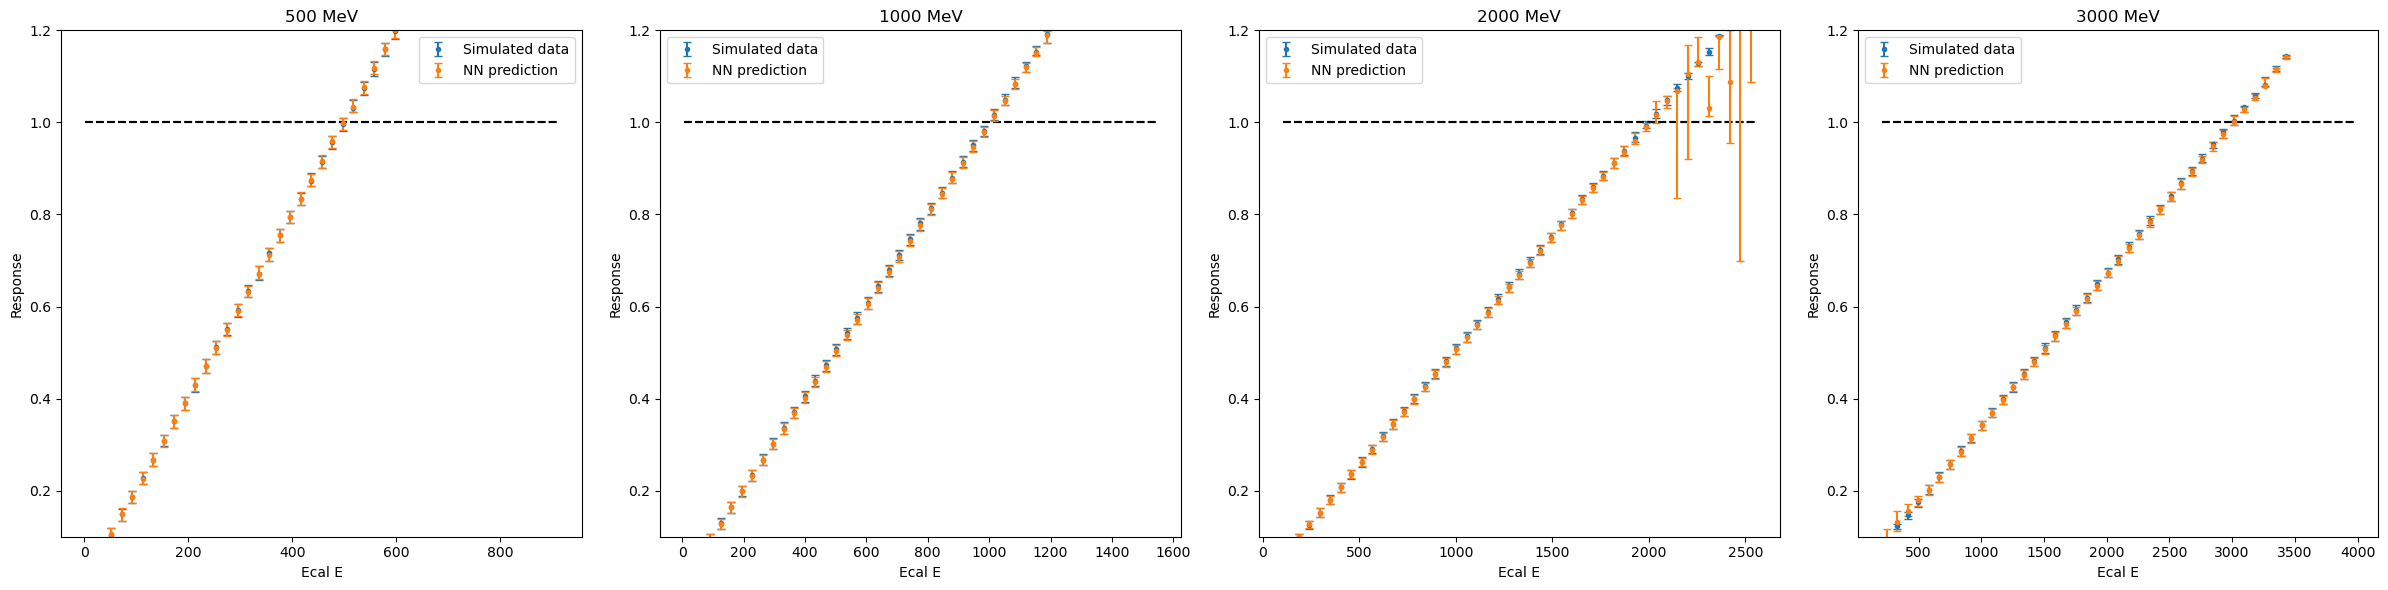

Elapsed time: 0.50 seconds


In [36]:
from scipy.stats import binned_statistic

start = time.time()
Ecal_frac_distr, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten()

for i, energy in enumerate(energies):
    # Plot the data profile first

    plotProfile(
        E_val[i],
        R_val[i],
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal E",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal E",
        leg="Simulated data"
    )

    # Generate test inputs for NN model

    # Feed to model
    I_test = torch.tensor(np.column_stack((z_val[i], E_val[i])), dtype=torch.float)
    with torch.no_grad():
        R_pred = model[energy](I_test).squeeze().numpy()

    plotProfile(
        E_val[i],
        R_pred,
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal E",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal E",
        leg="NN prediction"
    )
    
    axs[i].set_title(f"{energy} MeV")
    axs[i].set_ylim(0.1, 1.2)
    axs[i].legend()
plt.tight_layout()
plt.show()
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

#### R(E) fractional resolution comparison

/var/folders/p0/tx2v332j185flgv5yf82by0c0000gn/T/ipykernel_10567/131959438.py:43: RuntimeWarning: invalid value encountered in divide
  res_data/res_NN,
/var/folders/p0/tx2v332j185flgv5yf82by0c0000gn/T/ipykernel_10567/131959438.py:21: RuntimeWarning: invalid value encountered in divide
  res_data=(loe+hie)/median
/var/folders/p0/tx2v332j185flgv5yf82by0c0000gn/T/ipykernel_10567/131959438.py:38: RuntimeWarning: invalid value encountered in divide
  res_NN=(loe+hie)/median
/var/folders/p0/tx2v332j185flgv5yf82by0c0000gn/T/ipykernel_10567/131959438.py:21: RuntimeWarning: invalid value encountered in divide
  res_data=(loe+hie)/median
/var/folders/p0/tx2v332j185flgv5yf82by0c0000gn/T/ipykernel_10567/131959438.py:38: RuntimeWarning: invalid value encountered in divide
  res_NN=(loe+hie)/median
/var/folders/p0/tx2v332j185flgv5yf82by0c0000gn/T/ipykernel_10567/131959438.py:43: RuntimeWarning: invalid value encountered in divide
  res_data/res_NN,


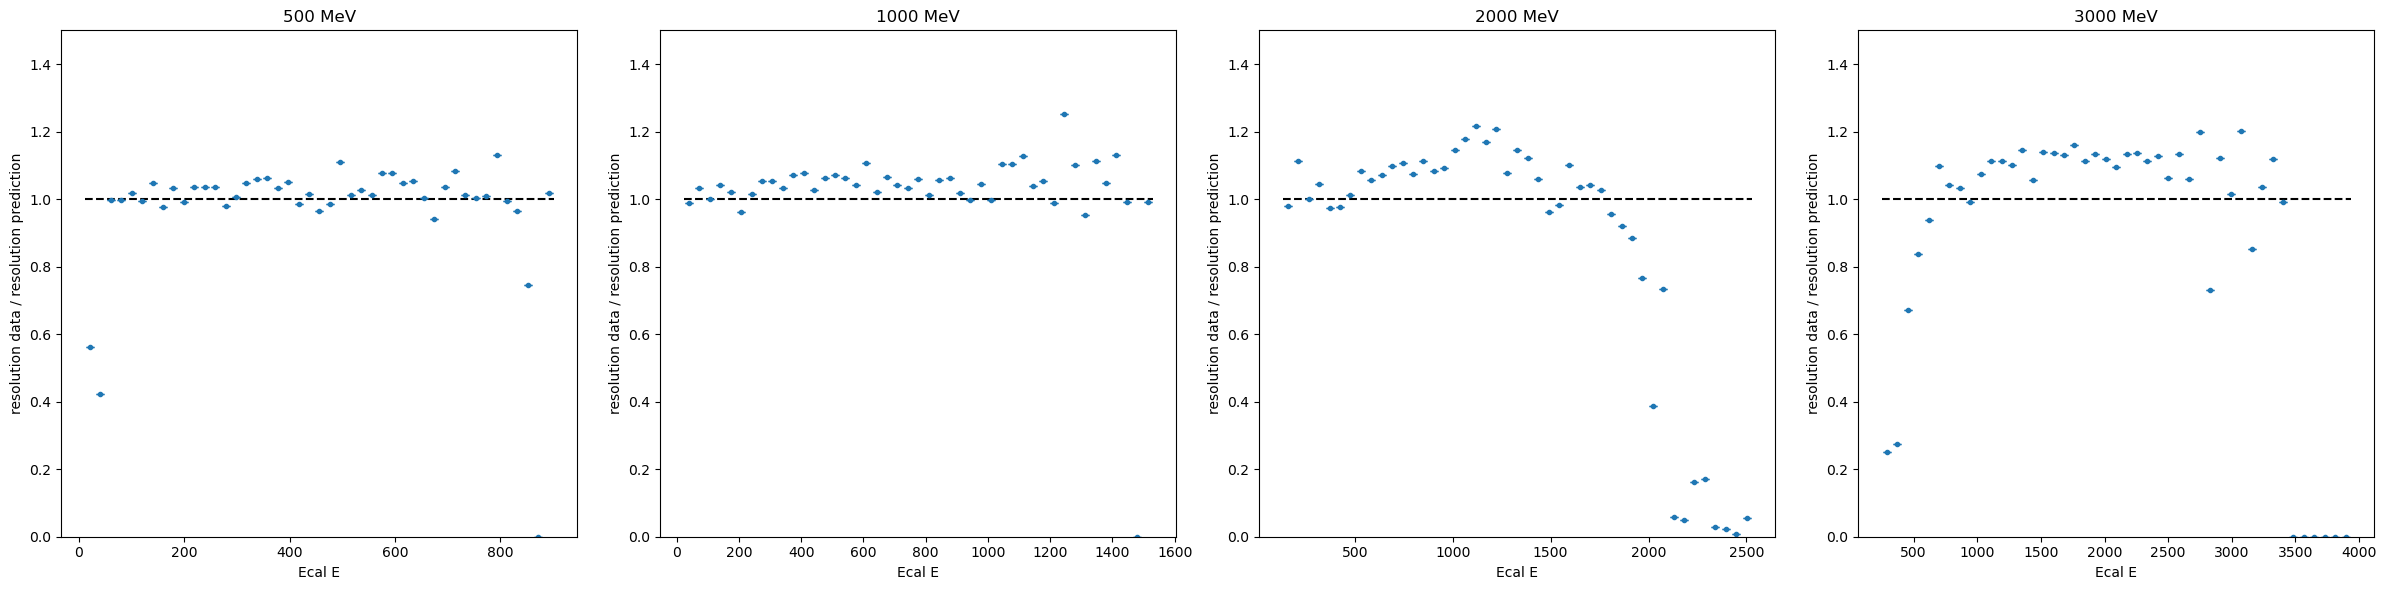

Elapsed time: 0.47 seconds


In [37]:
from scipy.stats import binned_statistic

start = time.time()
Ecal_frac_distr, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten()

for i, energy in enumerate(energies):
    # Plot the data profile first

    bin_centers, median, (loe, hie), fit=plotProfile(
        E_val[i],
        R_val[i],
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal E",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal E",
        leg="Simulated data",plot=False
    )
    res_data=(loe+hie)/median

    I_test = torch.tensor(np.column_stack((z_val[i], E_val[i])), dtype=torch.float)
    with torch.no_grad():
        R_pred = model[energy](I_test).squeeze().numpy()

    bin_centers, median, (loe, hie), fit =plotProfile(
        E_val[i],
        R_pred,
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal E",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal E",
        leg="NN prediction",plot=False
    )
    res_NN=(loe+hie)/median

    
    plotProfile(
        bin_centers,
        res_data/res_NN,
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal E",
        ytitle="resolution data / resolution prediction",
        nbins=len(median),
        text="resolution ratio vs E"
    )
    
    axs[i].set_title(f"{energy} MeV")
    axs[i].set_ylim(0, 1.5)
plt.tight_layout()
plt.show()
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

#### R_data/R_NN (Ecal_E)

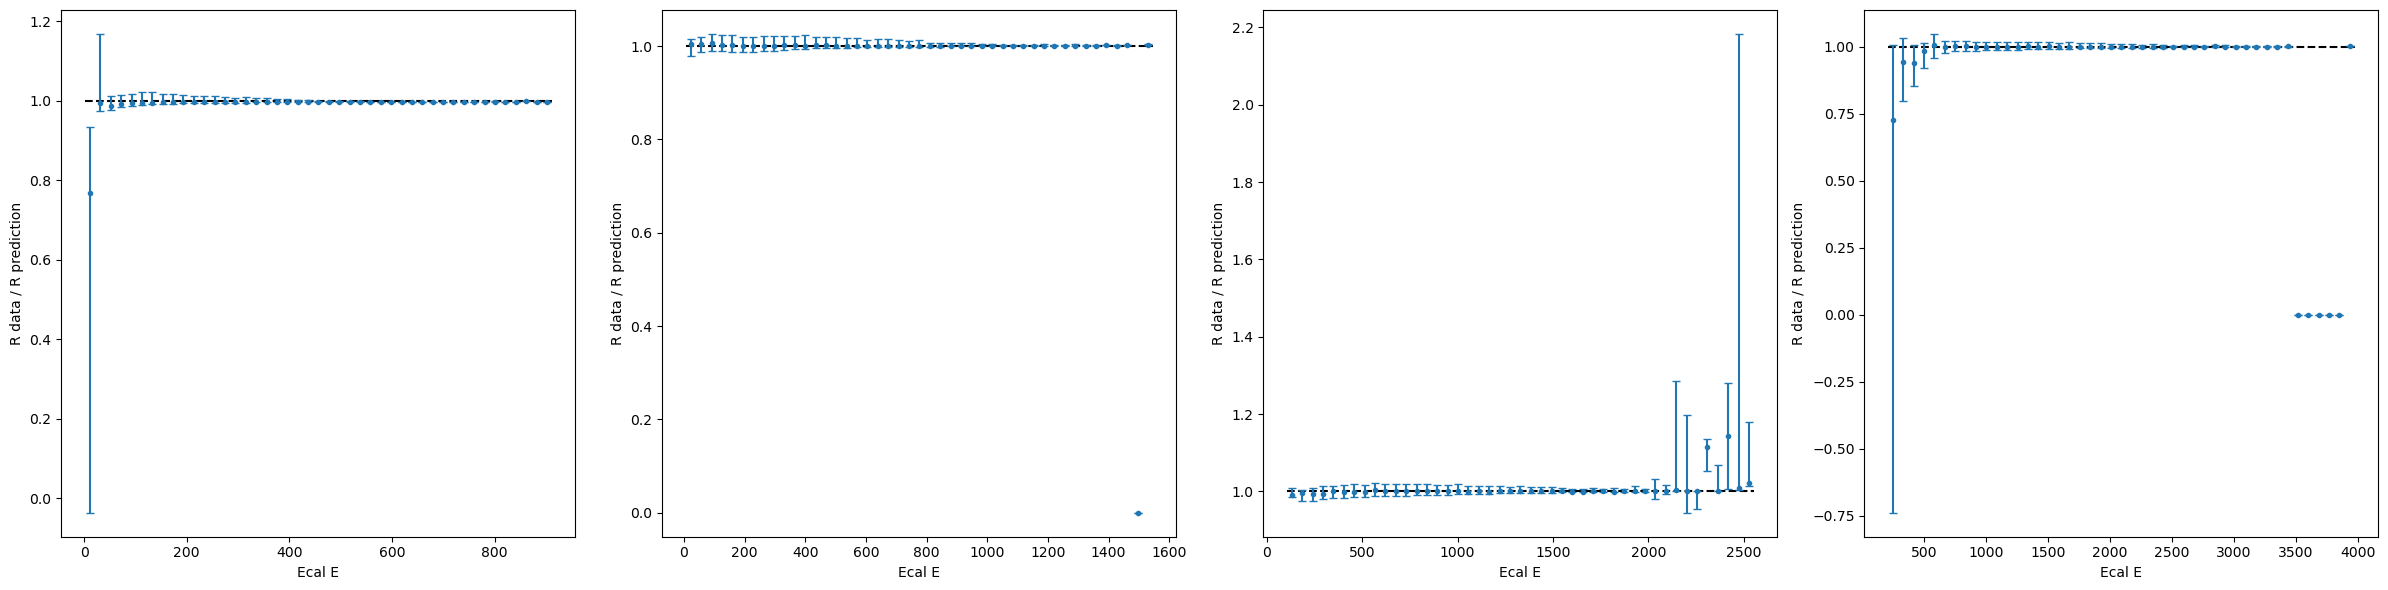

In [38]:
ratio={}
Ecal_frac_distr, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten()

for i, energy in enumerate(energies):

    # Feed to model
    I_test = torch.tensor(np.column_stack((z_val[i], E_val[i])), dtype=torch.float)
    with torch.no_grad():
        R_pred = model[energy](I_test).squeeze().numpy()
    
    ratio[energy]=R_val[i]/R_pred

    plotProfile(
        E_val[i],
        ratio[energy],
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal E",
        ytitle="R data / R prediction",
        nbins=45,
        text="R ratio vs Ecal_E"
    )
    # axs[i].set_ylim(0.6, 1.4)


plt.tight_layout()
plt.show()

#### E_neutron_NN_pred(z)

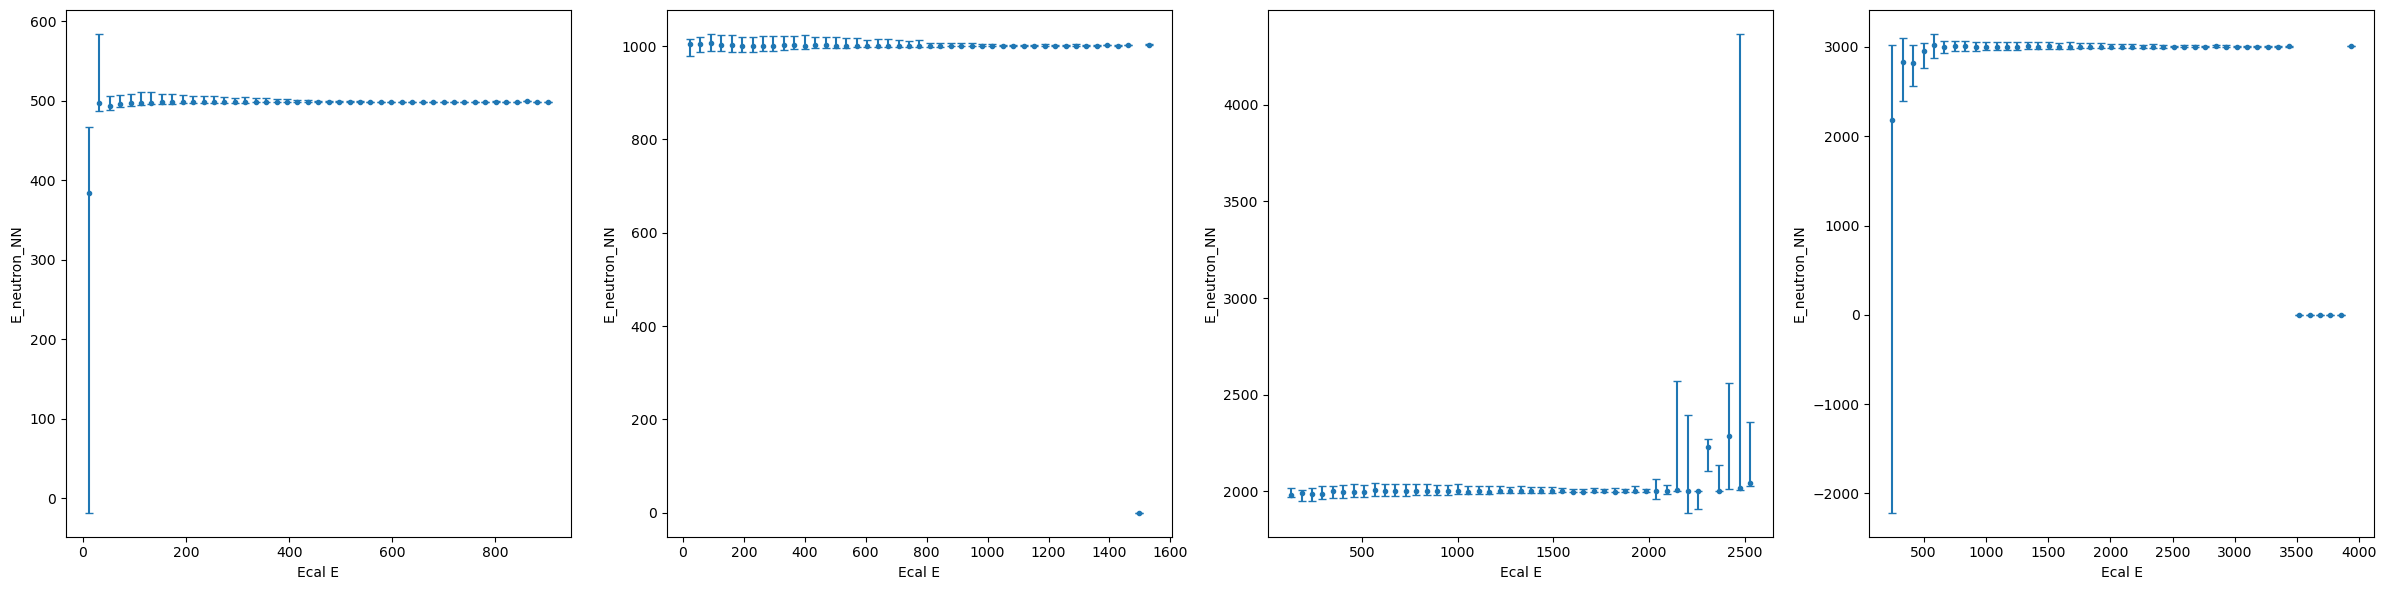

In [39]:
Ecal_frac_distr, axs = plt.subplots(1, 4, figsize=(24, 6))
axs = axs.flatten()
E_neutron_pred={}
for i, energy in enumerate(energies):
    
    # Feed to model
    I_test = torch.tensor(np.column_stack((z_val[i], E_val[i])), dtype=torch.float)
    with torch.no_grad():
        R_pred = model[energy](I_test).squeeze().numpy()
     
    E_neutron_pred[energy]=R_val[i]*energy/R_pred

    plotProfile(
        E_val[i],
        E_neutron_pred[energy],
        name=f"profile_Ecal_{energy}",
        ax=axs[i],
        xtitle="Ecal E",
        ytitle="E_neutron_NN",
        nbins=45,
        text="predicted neutron energy vs Ecal E",
        show_y1=False
    )


plt.tight_layout()
plt.show()

# NN combined data

In [31]:
Ecal_z_all=[]
Ecal_E_all=[]
Ecal_sigma_z_all=[]
Ecal_sigma_t_all=[]
R_Ecal_all=[]

In [32]:
for i in energies:
    Ecal_z_all = np.concatenate([Ecal_z_all, Ecal_z_clean[i]])
    Ecal_E_all = np.concatenate([Ecal_E_all, Ecal_E_clean[i]])
    
    Ecal_sigma_z_all = np.concatenate([Ecal_sigma_z_all, Ecal_sigma_z_clean[i]])
    Ecal_sigma_t_all = np.concatenate([Ecal_sigma_t_all, Ecal_sigma_t_clean[i]])
    
    R_Ecal_all = np.concatenate([R_Ecal_all, R_clean_Ecal[i]])


In [33]:
import torch
import torch.nn as nn
import math
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


start = time.time()
dtype = torch.float
device = torch.device("cpu")

z_val={}
E_val={}
sigma_z_val={}
sigma_t_val={}
R_val={}
gun_E_val={}
O_pred={}   #predicted output
a={}
b={}
model={}
loss={}
iteration={}
# device = torch.device("cuda:0") # Uncomment this to run on GPU
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True)

# z_train,z_val,E_train,E_val,R_train,R_val,gun_E_train,gun_E_val=train_test_split(Ecal_z_all,Ecal_E_all,R_Ecal_all,gun_E_Ecal_all,test_size=0.2)
z_train,z_val,E_train,E_val,sigma_z_train,sigma_z_val,sigma_t_train,sigma_t_val,R_train,R_val=train_test_split(Ecal_z_all,Ecal_E_all,Ecal_sigma_z_all,Ecal_sigma_t_all,R_Ecal_all,test_size=0.2)

    
# I_train = torch.tensor(np.column_stack((z_train,E_train,gun_E_train)), dtype=torch.float)
I_train = torch.tensor(np.column_stack((z_train,E_train,sigma_z_train,sigma_t_train)), dtype=torch.float)
O_train = torch.tensor(R_train, dtype=torch.float).unsqueeze(1)
# I_val = torch.tensor(np.column_stack((z_val,E_val,gun_E_val)), dtype=torch.float)
I_val = torch.tensor(np.column_stack((z_val,E_val,sigma_z_val,sigma_t_val)), dtype=torch.float)
O_val = torch.tensor(R_val, dtype=torch.float).unsqueeze(1)
  
model=nn.Sequential(nn.Linear(4,8),     
                    nn.ReLU(),
                    nn.Linear(8,16),
                    nn.ReLU(),
                    nn.Linear(16,8),
                    nn.ReLU(),
                    nn.Linear(8,1)
                   )
loss_fn=torch.nn.L1Loss()     
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

loss=[]
iteration=[]

for step in range(50000):
        # Forward pass: compute predicted y
    model.train()
    optimizer.zero_grad(set_to_none=True)
    O_pred = model(I_train)
    train_loss = loss_fn(O_pred,O_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        O_pred_val = model(I_val)
        val_loss = loss_fn(O_pred_val, O_val).item()
    loss.append(train_loss.item())
    iteration.append(step)
        
    prev_count = early_stopping.no_improvement_count
    # early_stopping.check_early_stop(val_loss)
    # if early_stopping.stop_training:
    #     print(f"Early stopping at iteration {step} with val_loss {val_loss:.6e}")
    #     break


        
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

Elapsed time: 1611.37 seconds


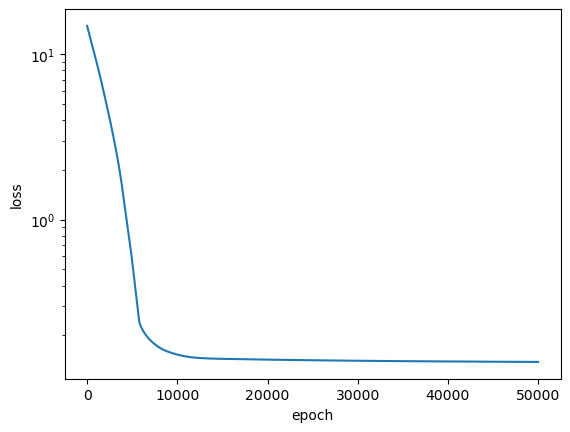

In [34]:
plt.plot(iteration,loss)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.yscale("log")

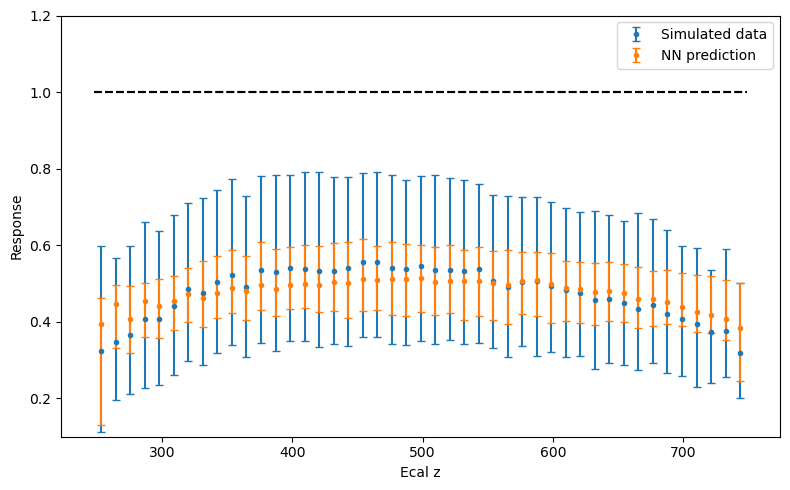

Elapsed time: 0.33 seconds


In [37]:
from scipy.stats import binned_statistic

start = time.time()

fig, ax = plt.subplots(figsize=(8, 5))
plotProfile(
        z_val,
        R_val,
        name=f"profile_Ecal",
        xtitle="Ecal z",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal z",
        leg="Simulated data",
        ax=ax
    )

    # Generate test inputs for NN model

    # Feed to model
# I_test = torch.tensor(np.column_stack((z_val, E_val,gun_E_val)), dtype=torch.float)
I_test = torch.tensor(np.column_stack((z_val, E_val,sigma_z_val,sigma_t_val)), dtype=torch.float)

with torch.no_grad():
    R_pred = model(I_test).squeeze().numpy()
plotProfile(
        z_val,
        R_pred,
        name=f"profile_Ecal",
        xtitle="Ecal z",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal z",
        leg="NN prediction",
    ax=ax
    )
    
ax.set_ylim(0.1, 1.2)
ax.legend()
plt.tight_layout()
plt.show()
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

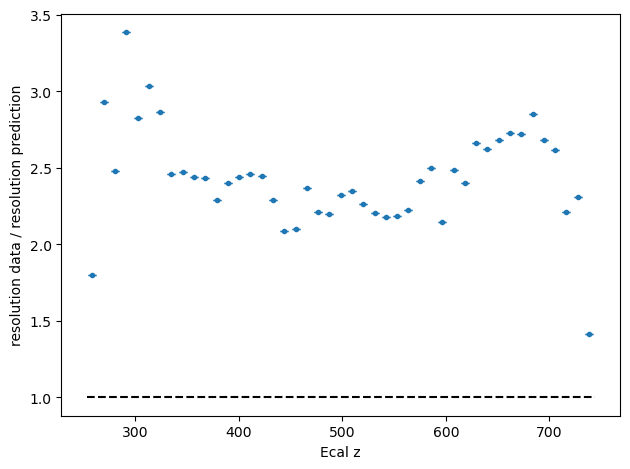

Elapsed time: 0.18 seconds


In [36]:
from scipy.stats import binned_statistic

start = time.time()
Ecal_frac_distr, axs = plt.subplots()


bin_centers, median, (loe, hie), fit=plotProfile(
        z_val,
        R_val,
        name=f"profile_Ecal",
        ax=axs,
        xtitle="Ecal z",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal z",
        leg="Simulated data",plot=False
    )
res_data=(loe+hie)/median

# I_test = torch.tensor(np.column_stack((z_val, E_val,gun_E_val)), dtype=torch.float)
I_test = torch.tensor(np.column_stack((z_val, E_val,sigma_z_val,sigma_t_val)), dtype=torch.float)
with torch.no_grad():
        R_pred = model(I_test).squeeze().numpy()

bin_centers, median, (loe, hie), fit =plotProfile(
        z_val,
        R_pred,
        name=f"profile_Ecal",
        ax=axs,
        xtitle="Ecal z",
        ytitle="Response",
        nbins=45,
        text="R vs Ecal z",
        leg="NN prediction",plot=False
    )
res_NN=(loe+hie)/median

    
plotProfile(
        bin_centers,
        res_data/res_NN,
        name=f"profile_Ecal",
        ax=axs,
        xtitle="Ecal z",
        ytitle="resolution data / resolution prediction",
        nbins=len(median),
        text="resolution ratio vs z"
    )
    

plt.tight_layout()
plt.show()
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")